# Loading and imports

In [9]:
# Project setup and imports
import os, glob, warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import mannwhitneyu, kruskal, spearmanr
from statsmodels.stats.multitest import multipletests
import networkx as nx

warnings.filterwarnings('ignore')

# Config 
DATA_DIR = '/media/RCPNAS/Data/Delirium/Delirium_Rania/Preproc_new_clean'

# Atlas structure: Combined_HCPex_426
# - Labels 1-360: Cortical regions (Glasser MMP1, 180 parcels × 2 hemispheres)
# - Labels 361-426: Subcortical regions (HCPex, 66 regions)
CORTICAL_LABELS = set(range(1, 361))  # 1-360
SUBCORTICAL_LABELS = set(range(361, 427))  # 361-426
N_ROIS = 426

# Define groups
GROUPS = {
    'Delirium': ['DA', 'FS', 'CG', 'PO', 'PB', 'FSE', 'GL', 'LL', 'MF', 'SA','KJ','PM'],
    'ICU_Control': ['AF' , 'DA2'],
    'Unassigned': []
}

print(f"Data directory: {DATA_DIR}")
print(f"Cortical labels: 1-360 ({len(CORTICAL_LABELS)} regions)")
print(f"Subcortical labels: 361-426 ({len(SUBCORTICAL_LABELS)} regions)")
print(f"Total ROIs: {N_ROIS}")


/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Data directory: /media/RCPNAS/Data/Delirium/Delirium_Rania/Preproc_new_clean
Cortical labels: 1-360 (360 regions)
Subcortical labels: 361-426 (66 regions)
Total ROIs: 426


## Data Loading

Load all subject connectomes (uncorrected and size-corrected) and ROI volumes.


In [10]:
# Load all subject connectomes (uncorrected and size-corrected)

# Find all subjects with both connectomes
subjects = []
uncorrected_files = {}
corrected_files = {}
volume_files = {}

for subj_dir in glob.glob(os.path.join(DATA_DIR, 'sub-*')):
    subj_id = os.path.basename(subj_dir)
    subj_short = subj_id.replace('sub-', '')
    
    uncorr_path = os.path.join(subj_dir, 'connectome_local', f'{subj_id}_SC_sift2.csv')
    corr_path = os.path.join(subj_dir, 'connectome_local', f'{subj_id}_SC_sift2_sizecorr.csv')
    vol_path = os.path.join(subj_dir, 'connectome_local', f'{subj_id}_node_volumes.csv')
    
    if os.path.exists(uncorr_path) and os.path.exists(corr_path):
        subjects.append(subj_short)
        uncorrected_files[subj_short] = uncorr_path
        corrected_files[subj_short] = corr_path
        if os.path.exists(vol_path):
            volume_files[subj_short] = vol_path

print(f"Found {len(subjects)} subjects with both uncorrected and size-corrected connectomes")
print(f"Subjects: {sorted(subjects)}")

# Load connectomes for all subjects
connectomes_uncorr = {}
connectomes_corr = {}
volumes = {}

for subj in subjects:
    # Load connectomes
    connectomes_uncorr[subj] = np.loadtxt(uncorrected_files[subj], delimiter=',')
    connectomes_corr[subj] = np.loadtxt(corrected_files[subj], delimiter=',')
    
    # Load volumes if available
    if subj in volume_files:
        vol_df = pd.read_csv(volume_files[subj])
        volumes[subj] = vol_df['voxels'].values
    
    # Verify dimensions
    assert connectomes_uncorr[subj].shape == connectomes_corr[subj].shape, \
        f"Shape mismatch for {subj}"
    assert connectomes_uncorr[subj].shape[0] == N_ROIS, \
        f"Expected {N_ROIS} ROIs, got {connectomes_uncorr[subj].shape[0]} for {subj}"

print(f"\nLoaded connectomes for {len(connectomes_uncorr)} subjects")
print(f"Connectome shape: {connectomes_uncorr[subjects[0]].shape}")
if volumes:
    print(f"Loaded volumes for {len(volumes)} subjects")


Found 14 subjects with both uncorrected and size-corrected connectomes
Subjects: ['AF', 'CG', 'DA', 'DA2', 'FS', 'FSE', 'GL', 'KJ', 'LL', 'MF', 'PB', 'PM', 'PO', 'SA']



Loaded connectomes for 14 subjects
Connectome shape: (426, 426)
Loaded volumes for 14 subjects


## Group-Averaged Connectome Comparison

Computing and visualizing group-averaged connectomes across all subjects to see the overall pattern of size correction effects.


Computing group-averaged connectomes across 14 subjects...

Successfully loaded 14 subjects: FSE, MF, LL, PM, DA, FS, KJ, GL, PB, AF, CG, SA, PO, DA2

Average connectome shape: (426, 426)
Sift2 average stats: Mean=1.0057e+02, Max=9.0877e+04
SizeCorr average stats: Mean=1.4593e-01, Max=2.7276e+01



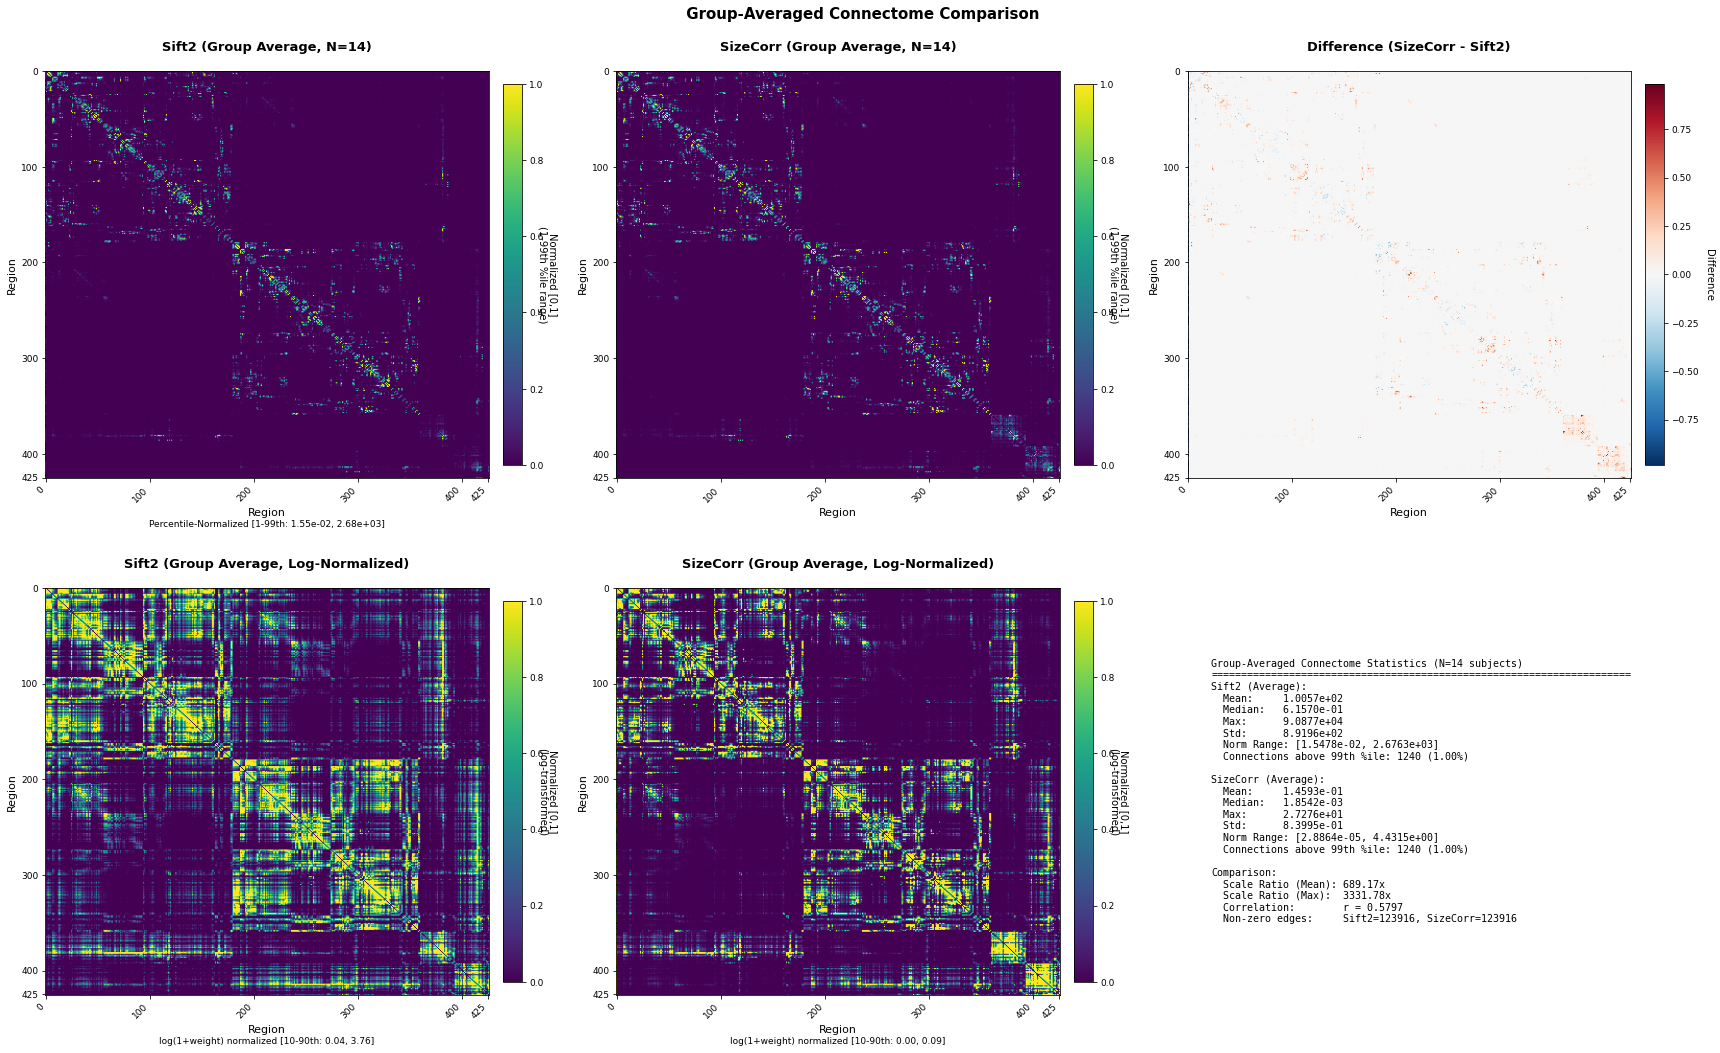


Figure saved: group_averaged_connectome_comparison.png


In [3]:
# Compute group-averaged connectomes across all subjects

if len(subjects) > 0:
    print(f"Computing group-averaged connectomes across {len(subjects)} subjects...\n")
    
    # Load all connectomes and compute averages
    sift2_matrices = []
    sizecorr_matrices = []
    loaded_subjects = []
    
    for subj in subjects:
        if subj in connectomes_uncorr and subj in connectomes_corr:
            sift2_matrix = connectomes_uncorr[subj]
            sizecorr_matrix = connectomes_corr[subj]
            
            # Ensure same shape
            if sift2_matrix.shape == sizecorr_matrix.shape:
                # Symmetrize and zero diagonal
                sift2_sym = 0.5 * (sift2_matrix + sift2_matrix.T)
                sizecorr_sym = 0.5 * (sizecorr_matrix + sizecorr_matrix.T)
                np.fill_diagonal(sift2_sym, 0.0)
                np.fill_diagonal(sizecorr_sym, 0.0)
                
                # Handle NaN and inf values - replace with 0
                sift2_sym = np.nan_to_num(sift2_sym, nan=0.0, posinf=0.0, neginf=0.0)
                sizecorr_sym = np.nan_to_num(sizecorr_sym, nan=0.0, posinf=0.0, neginf=0.0)
                
                sift2_matrices.append(sift2_sym)
                sizecorr_matrices.append(sizecorr_sym)
                loaded_subjects.append(subj)
    
    if len(sift2_matrices) > 0:
        print(f"Successfully loaded {len(sift2_matrices)} subjects: {', '.join(loaded_subjects)}\n")
        
        # Compute average connectomes
        sift2_avg = np.mean(np.array(sift2_matrices), axis=0)
        sizecorr_avg = np.mean(np.array(sizecorr_matrices), axis=0)
        
        # Final NaN check and cleanup
        sift2_avg = np.nan_to_num(sift2_avg, nan=0.0, posinf=0.0, neginf=0.0)
        sizecorr_avg = np.nan_to_num(sizecorr_avg, nan=0.0, posinf=0.0, neginf=0.0)
        
        print(f"Average connectome shape: {sift2_avg.shape}")
        print(f"Sift2 average stats: Mean={np.mean(sift2_avg[sift2_avg > 0]):.4e}, Max={np.max(sift2_avg):.4e}")
        print(f"SizeCorr average stats: Mean={np.mean(sizecorr_avg[sizecorr_avg > 0]):.4e}, Max={np.max(sizecorr_avg):.4e}\n")
        
        # Use wider percentile range (1-99th) to reduce clipping and show more detail
        percentile_range = (1, 99)
        
        # Normalize Sift2 average to its own percentile range
        sift2_avg_nonzero = sift2_avg[sift2_avg > 0]
        if len(sift2_avg_nonzero) > 0:
            sift2_p1, sift2_p99 = np.percentile(sift2_avg_nonzero, percentile_range)
            sift2_avg_clipped = np.clip(sift2_avg, sift2_p1, sift2_p99)
            if sift2_p99 > sift2_p1:
                sift2_avg_norm = (sift2_avg_clipped - sift2_p1) / (sift2_p99 - sift2_p1)
            else:
                sift2_avg_norm = np.zeros_like(sift2_avg)
            sift2_avg_norm[sift2_avg < sift2_p1] = 0
            # For values above 99th percentile, use continuous mapping
            above_mask = sift2_avg > sift2_p99
            if np.sum(above_mask) > 0:
                max_val = np.max(sift2_avg[above_mask])
                if max_val > sift2_p99:
                    sift2_avg_norm[above_mask] = 1.0 + 0.5 * (sift2_avg[above_mask] - sift2_p99) / (max_val - sift2_p99 + 1e-10)
                    sift2_avg_norm[above_mask] = np.clip(sift2_avg_norm[above_mask], 0, 1)
        else:
            sift2_avg_norm = np.zeros_like(sift2_avg)
            sift2_p1, sift2_p99 = 0, 0
        
        # Normalize SizeCorr average to its own percentile range 
        sizecorr_avg_nonzero = sizecorr_avg[sizecorr_avg > 0]
        if len(sizecorr_avg_nonzero) > 0:
            sizecorr_p1, sizecorr_p99 = np.percentile(sizecorr_avg_nonzero, percentile_range)
            sizecorr_avg_clipped = np.clip(sizecorr_avg, sizecorr_p1, sizecorr_p99)
            if sizecorr_p99 > sizecorr_p1:
                sizecorr_avg_norm = (sizecorr_avg_clipped - sizecorr_p1) / (sizecorr_p99 - sizecorr_p1)
            else:
                sizecorr_avg_norm = np.zeros_like(sizecorr_avg)
            sizecorr_avg_norm[sizecorr_avg < sizecorr_p1] = 0
            # For values above 99th percentile, use continuous mapping
            above_mask = sizecorr_avg > sizecorr_p99
            if np.sum(above_mask) > 0:
                max_val = np.max(sizecorr_avg[above_mask])
                if max_val > sizecorr_p99:
                    sizecorr_avg_norm[above_mask] = 1.0 + 0.5 * (sizecorr_avg[above_mask] - sizecorr_p99) / (max_val - sizecorr_p99 + 1e-10)
                    sizecorr_avg_norm[above_mask] = np.clip(sizecorr_avg_norm[above_mask], 0, 1)
        else:
            sizecorr_avg_norm = np.zeros_like(sizecorr_avg)
            sizecorr_p1, sizecorr_p99 = 0, 0
        
        fig, axes = plt.subplots(2, 3, figsize=(24, 16))
        
        # Common colorbar parameters
        cbar_fraction = 0.04
        cbar_pad = 0.03  # Increased padding
        cbar_labelpad = 15  # Increased label padding
        cbar_labelsize = 10
        cbar_ticksize = 9
        
        # Helper function to set improved axis ticks
        def set_axis_ticks(ax, n_regions=426, tick_interval=100, fontsize=9, x_rotation=45):
            tick_locations = np.arange(0, n_regions, tick_interval)
            if tick_locations[-1] != n_regions - 1:
                tick_locations = np.append(tick_locations, n_regions - 1)
            if len(tick_locations) > 7:
                key_indices = [0, len(tick_locations)//4, len(tick_locations)//2, 
                              3*len(tick_locations)//4, -1]
                tick_locations = tick_locations[key_indices]
            ax.set_xticks(tick_locations)
            ax.set_yticks(tick_locations)
            ax.set_xticklabels(tick_locations, fontsize=fontsize, rotation=x_rotation, ha='right')
            ax.set_yticklabels(tick_locations, fontsize=fontsize, rotation=0)
        
        # Row 1: Percentile-normalized averaged connectomes 
        im1 = axes[0, 0].imshow(sift2_avg_norm, cmap='viridis', aspect='auto', vmin=0, vmax=1)
        axes[0, 0].set_title(f'Sift2 (Group Average, N={len(loaded_subjects)})', 
                            fontsize=13, fontweight='bold', pad=20)
        axes[0, 0].text(0.5, -0.12, f'Percentile-Normalized [1-99th: {sift2_p1:.2e}, {sift2_p99:.2e}]', 
                       transform=axes[0, 0].transAxes, ha='center', fontsize=9)
        axes[0, 0].set_xlabel('Region', fontsize=11)
        axes[0, 0].set_ylabel('Region', fontsize=11)
        set_axis_ticks(axes[0, 0], n_regions=sift2_avg_norm.shape[0], tick_interval=100, fontsize=9, x_rotation=45)
        cbar1 = plt.colorbar(im1, ax=axes[0, 0], fraction=cbar_fraction, pad=cbar_pad)
        cbar1.set_label('Normalized [0,1]\n(1-99th %ile range)', 
                       labelpad=cbar_labelpad, fontsize=cbar_labelsize, rotation=270)
        cbar1.ax.tick_params(labelsize=cbar_ticksize)
        
        im2 = axes[0, 1].imshow(sizecorr_avg_norm, cmap='viridis', aspect='auto', vmin=0, vmax=1)
        axes[0, 1].set_title(f'SizeCorr (Group Average, N={len(loaded_subjects)})', 
                            fontsize=13, fontweight='bold', pad=20)
        axes[0, 1].set_xlabel('Region', fontsize=11)
        axes[0, 1].set_ylabel('Region', fontsize=11)
        set_axis_ticks(axes[0, 1], n_regions=sizecorr_avg_norm.shape[0], tick_interval=100, fontsize=9, x_rotation=45)
        cbar2 = plt.colorbar(im2, ax=axes[0, 1], fraction=cbar_fraction, pad=cbar_pad)
        cbar2.set_label('Normalized [0,1]\n(1-99th %ile range)', 
                       labelpad=cbar_labelpad, fontsize=cbar_labelsize, rotation=270)
        cbar2.ax.tick_params(labelsize=cbar_ticksize)
        
        # Difference plot
        diff_norm = sizecorr_avg_norm - sift2_avg_norm
        vmax_diff = np.max(np.abs(diff_norm)) if np.max(np.abs(diff_norm)) > 0 else 1.0
        im3 = axes[0, 2].imshow(diff_norm, cmap='RdBu_r', aspect='auto', 
                               vmin=-vmax_diff, vmax=vmax_diff)
        axes[0, 2].set_title('Difference (SizeCorr - Sift2)', 
                            fontsize=13, fontweight='bold', pad=20)
        axes[0, 2].set_xlabel('Region', fontsize=11)
        axes[0, 2].set_ylabel('Region', fontsize=11)
        set_axis_ticks(axes[0, 2], n_regions=diff_norm.shape[0], tick_interval=100, fontsize=9, x_rotation=45)
        cbar3 = plt.colorbar(im3, ax=axes[0, 2], fraction=cbar_fraction, pad=cbar_pad)
        cbar3.set_label('Difference', labelpad=cbar_labelpad, fontsize=cbar_labelsize, rotation=270)
        cbar3.ax.tick_params(labelsize=cbar_ticksize)
        
        # Row 2: Log-transformed visualization with separate percentile normalization
        # This normalizes each to its own percentile range to show relative structure
        # (similar to top row approach, but on log-transformed data)
        sift2_avg_log = np.log1p(sift2_avg)
        sizecorr_avg_log = np.log1p(sizecorr_avg)
        
        # Normalize Sift2 log to its own percentile range
        sift2_log_nonzero = sift2_avg_log[sift2_avg_log > 0]
        if len(sift2_log_nonzero) > 0:
            sift2_log_p10, sift2_log_p90 = np.percentile(sift2_log_nonzero, [10, 90])
            sift2_log_clipped = np.clip(sift2_avg_log, sift2_log_p10, sift2_log_p90)
            if sift2_log_p90 > sift2_log_p10:
                sift2_log_norm = (sift2_log_clipped - sift2_log_p10) / (sift2_log_p90 - sift2_log_p10)
            else:
                sift2_log_norm = np.zeros_like(sift2_avg_log)
            sift2_log_norm[sift2_avg_log < sift2_log_p10] = 0
            sift2_log_norm[sift2_avg_log > sift2_log_p90] = 1
        else:
            sift2_log_norm = np.zeros_like(sift2_avg_log)
            sift2_log_p10, sift2_log_p90 = 0, 0
        
        # Normalize SizeCorr log to its own percentile range
        sizecorr_log_nonzero = sizecorr_avg_log[sizecorr_avg_log > 0]
        if len(sizecorr_log_nonzero) > 0:
            sizecorr_log_p10, sizecorr_log_p90 = np.percentile(sizecorr_log_nonzero, [10, 90])
            sizecorr_log_clipped = np.clip(sizecorr_avg_log, sizecorr_log_p10, sizecorr_log_p90)
            if sizecorr_log_p90 > sizecorr_log_p10:
                sizecorr_log_norm = (sizecorr_log_clipped - sizecorr_log_p10) / (sizecorr_log_p90 - sizecorr_log_p10)
            else:
                sizecorr_log_norm = np.zeros_like(sizecorr_avg_log)
            sizecorr_log_norm[sizecorr_avg_log < sizecorr_log_p10] = 0
            sizecorr_log_norm[sizecorr_avg_log > sizecorr_log_p90] = 1
        else:
            sizecorr_log_norm = np.zeros_like(sizecorr_avg_log)
            sizecorr_log_p10, sizecorr_log_p90 = 0, 0
        
        # Display normalized versions (both on [0,1] scale for fair visual comparison)
        im4 = axes[1, 0].imshow(sift2_log_norm, cmap='viridis', aspect='auto', vmin=0, vmax=1)
        axes[1, 0].set_title('Sift2 (Group Average, Log-Normalized)', 
                            fontsize=13, fontweight='bold', pad=20)
        axes[1, 0].text(0.5, -0.12, f'log(1+weight) normalized [10-90th: {sift2_log_p10:.2f}, {sift2_log_p90:.2f}]', 
                       transform=axes[1, 0].transAxes, ha='center', fontsize=9)
        axes[1, 0].set_xlabel('Region', fontsize=11)
        axes[1, 0].set_ylabel('Region', fontsize=11)
        set_axis_ticks(axes[1, 0], n_regions=sift2_avg_log.shape[0], tick_interval=100, fontsize=9, x_rotation=45)
        cbar4 = plt.colorbar(im4, ax=axes[1, 0], fraction=cbar_fraction, pad=cbar_pad)
        cbar4.set_label('Normalized [0,1]\n(log-transformed)', 
                       labelpad=cbar_labelpad, fontsize=cbar_labelsize, rotation=270)
        cbar4.ax.tick_params(labelsize=cbar_ticksize)
        
        im5 = axes[1, 1].imshow(sizecorr_log_norm, cmap='viridis', aspect='auto', vmin=0, vmax=1)
        axes[1, 1].set_title('SizeCorr (Group Average, Log-Normalized)', 
                            fontsize=13, fontweight='bold', pad=20)
        axes[1, 1].text(0.5, -0.12, f'log(1+weight) normalized [10-90th: {sizecorr_log_p10:.2f}, {sizecorr_log_p90:.2f}]', 
                       transform=axes[1, 1].transAxes, ha='center', fontsize=9)
        axes[1, 1].set_xlabel('Region', fontsize=11)
        axes[1, 1].set_ylabel('Region', fontsize=11)
        set_axis_ticks(axes[1, 1], n_regions=sizecorr_avg_log.shape[0], tick_interval=100, fontsize=9, x_rotation=45)
        cbar5 = plt.colorbar(im5, ax=axes[1, 1], fraction=cbar_fraction, pad=cbar_pad)
        cbar5.set_label('Normalized [0,1]\n(log-transformed)', 
                       labelpad=cbar_labelpad, fontsize=cbar_labelsize, rotation=270)
        cbar5.ax.tick_params(labelsize=cbar_ticksize)
        
        # Statistics and comparison
        axes[1, 2].axis('off')
        
        # Calculate statistics
        sift2_avg_stats = {
            'mean': np.mean(sift2_avg[sift2_avg > 0]),
            'median': np.median(sift2_avg[sift2_avg > 0]),
            'max': np.max(sift2_avg),
            'std': np.std(sift2_avg[sift2_avg > 0])
        }
        
        sizecorr_avg_stats = {
            'mean': np.mean(sizecorr_avg[sizecorr_avg > 0]),
            'median': np.median(sizecorr_avg[sizecorr_avg > 0]),
            'max': np.max(sizecorr_avg),
            'std': np.std(sizecorr_avg[sizecorr_avg > 0])
        }
        
        # Correlation
        triu_indices = np.triu_indices_from(sift2_avg, k=1)
        sift2_flat = sift2_avg[triu_indices]
        sizecorr_flat = sizecorr_avg[triu_indices]
        valid_mask = (sift2_flat > 0) & (sizecorr_flat > 0)
        if np.sum(valid_mask) > 0:
            corr = np.corrcoef(sift2_flat[valid_mask], sizecorr_flat[valid_mask])[0, 1]
        else:
            corr = np.nan
        
        # Count clipped connections
        sizecorr_clipped_count = np.sum(sizecorr_avg > sizecorr_p99)
        sift2_clipped_count = np.sum(sift2_avg > sift2_p99)
        
        stats_text = f"""
Group-Averaged Connectome Statistics (N={len(loaded_subjects)} subjects)
{'='*70}
Sift2 (Average):
  Mean:     {sift2_avg_stats['mean']:.4e}
  Median:   {sift2_avg_stats['median']:.4e}
  Max:      {sift2_avg_stats['max']:.4e}
  Std:      {sift2_avg_stats['std']:.4e}
  Norm Range: [{sift2_p1:.4e}, {sift2_p99:.4e}]
  Connections above 99th %ile: {sift2_clipped_count} ({100*sift2_clipped_count/len(sift2_avg_nonzero):.2f}%)

SizeCorr (Average):
  Mean:     {sizecorr_avg_stats['mean']:.4e}
  Median:   {sizecorr_avg_stats['median']:.4e}
  Max:      {sizecorr_avg_stats['max']:.4e}
  Std:      {sizecorr_avg_stats['std']:.4e}
  Norm Range: [{sizecorr_p1:.4e}, {sizecorr_p99:.4e}]
  Connections above 99th %ile: {sizecorr_clipped_count} ({100*sizecorr_clipped_count/len(sizecorr_avg_nonzero):.2f}%)

Comparison:
  Scale Ratio (Mean): {sift2_avg_stats['mean'] / sizecorr_avg_stats['mean']:.2f}x
  Scale Ratio (Max):  {sift2_avg_stats['max'] / sizecorr_avg_stats['max']:.2f}x
  Correlation:        r = {corr:.4f}
  Non-zero edges:     Sift2={np.sum(sift2_avg > 0)}, SizeCorr={np.sum(sizecorr_avg > 0)}
"""
        
        axes[1, 2].text(0.05, 0.5, stats_text, fontsize=10, family='monospace',
                        verticalalignment='center', horizontalalignment='left',
                        transform=axes[1, 2].transAxes)
        
        # Adjust layout with more space for labels and titles
        plt.tight_layout(rect=[0, 0.08, 1, 0.97], h_pad=3.0, w_pad=2.0)
        plt.suptitle(' Group-Averaged Connectome Comparison', 
                    fontsize=15, fontweight='bold', y=0.99)
        plt.savefig(os.path.join(DATA_DIR, 'group_averaged_connectome_comparison.png'), dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"\nFigure saved: group_averaged_connectome_comparison.png")
        
    else:
        print("No subjects could be loaded for averaging.")
else:
    print("No subjects available for averaging.")


## Understanding the Analysis Results

### What is "Percentage Change" in Analysis 1?

In Analysis 1, we compute the **percentage change** for each ROI's total connectivity:

```
Percentage Change = ((Corrected - Uncorrected) / Uncorrected) × 100%
```

Where:
- **Uncorrected** = Total connectivity strength (sum of all edge weights) for an ROI in the original connectome
- **Corrected** = Total connectivity strength for the same ROI in the size-corrected connectome

### What Does Negative Percentage Change Mean?

A **negative percentage change** means that the size-corrected connectome has **lower values** than the uncorrected connectome.

**Example:**
- If an ROI had total connectivity of 1000 in the uncorrected connectome
- And 10 in the size-corrected connectome
- Percentage change = ((10 - 1000) / 1000) × 100% = **-99%**

This is **expected** because size correction divides edge weights by a factor related to ROI volumes, which typically **reduces** the absolute values. The correction factor is usually `1 / sqrt(volume_i × volume_j)`, so smaller ROIs get divided by smaller factors, but the overall effect is still a reduction.

### Why Are the Values Around -99%?

 
- Size correction reduces connectivity values by approximately **99%** on average
- The remaining ~1% represents the "corrected" connectivity
- This massive reduction is expected because:
  1. Original connectome values are typically much larger (e.g., in the thousands)
  2. Size correction normalizes by ROI volumes, dramatically scaling down values
  3. The correction aims to remove the bias from ROI size differences

### What We're Really Comparing

Even though both cortical and subcortical ROIs show large negative changes (~-99%), we're interested in:
- **Which type shows a LARGER absolute change?** (i.e., which is more affected)
- **Is the difference statistically significant?**
- **Is the effect size meaningful?**

In our case:
- Cortical: Mean = -99.81% (absolute change = 99.81%)
- Subcortical: Mean = -99.34% (absolute change = 99.34%)
- **Cortical ROIs show slightly larger changes** (0.47% difference)

---

## Understanding the Statistical Tests

### Mann-Whitney U Test (U-statistic)

**What it tests:**
- Tests whether two independent groups come from the same distribution
- Non-parametric (doesn't assume normal distribution)
- More robust to outliers than t-tests

**How it works:**
1. **Rank all values** from both groups together (smallest to largest)
2. **Sum the ranks** for one group (e.g., subcortical ROIs)
3. **Calculate U-statistic:**
   ```
   U = n1 × n2 + (n1 × (n1 + 1)) / 2 - R1
   ```
   Where:
   - n1, n2 = sample sizes of the two groups
   - R1 = sum of ranks for group 1

**Interpretation:**
- **U-statistic = 2.05e+06** in our case
- This is a very large number, which suggests the groups are different
- The exact value depends on sample sizes and rank distributions
- **Lower U** = more evidence for difference (but interpretation depends on sample sizes)

**our result:**
- U = 2,050,000 (very large, but with ~5,000 cortical and ~850 subcortical observations, this is expected)
- **p-value = 9.75e-152**  
- This is **extremely significant** - virtually impossible to get by chance
- **Conclusion:** Cortical and subcortical ROIs have **significantly different** percentage change distributions

---

### Cohen's d (Effect Size)

**What it measures:**
- The **standardized difference** between two groups
- Tells you how "big" the difference is, not just whether it's significant
- Important because with large sample sizes, even tiny differences can be statistically significant

**Formula:**
```
Cohen's d = (Mean₁ - Mean₂) / Pooled Standard Deviation
```

**Interpretation guidelines:**
- **|d| < 0.2**: Negligible effect
- **0.2 ≤ |d| < 0.5**: Small effect
- **0.5 ≤ |d| < 0.8**: Medium effect
- **|d| ≥ 0.8**: Large effect

**Your result:**
- **Cohen's d = 0.0384** = **Negligible effect** (since 0.0384 < 0.2)
- This means: Even though the difference is **highly statistically significant** (p < 0.001), the **practical difference** is negligible
- The difference between cortical (-99.81%) and subcortical (-99.34%) is only **0.47 percentage points**
- This is a **statistically detectable but practically negligible difference** - both groups are affected almost identically by size correction

**Why is the effect negligible?**
- Both cortical and subcortical ROIs are dramatically reduced by size correction (~99%)
- The difference between them (0.47%) is tiny compared to the overall change
- This suggests size correction affects both types **almost identically**, with only a minuscule preference for cortical ROIs
- With large sample sizes (thousands of observations), even tiny differences become statistically significant, but they may not be meaningful in practice

---

## Summary

1. **Negative percentage change** = Size correction reduces connectivity values (expected)
2. **~-99% change** = Values are reduced by ~99% (normal for this type of correction)
3. **U-statistic** = Shows groups are significantly different (p < 0.001)
4. **Cohen's d = 0.0384** = **Negligible** practical difference despite statistical significance
5. **Conclusion**: Size correction affects both types **almost identically** - the 0.47% difference is statistically detectable but practically negligible. Both cortical and subcortical ROIs are reduced by ~99% with minimal difference between them.


# Statistical analysis 

In [7]:
# Analysis 1: ROI-level effects - How much does each ROI's connectivity change?

print("=" * 80)
print("ANALYSIS 1: ROI-Level Effects of Size Correction")
print("=" * 80)

# For each ROI, compute the total connectivity (strength) before and after correction
# Then compute percentage change: (corrected - uncorrected) / uncorrected * 100

roi_effects = []  # Will store: subject, roi_idx, roi_type, total_uncorr, total_corr, pct_change, volume

for subj in subjects:
    uncorr = connectomes_uncorr[subj]
    corr = connectomes_corr[subj]
    
    # Symmetrize and zero diagonal
    uncorr_sym = 0.5 * (uncorr + uncorr.T)
    corr_sym = 0.5 * (corr + corr.T)
    np.fill_diagonal(uncorr_sym, 0.0)
    np.fill_diagonal(corr_sym, 0.0)
    
    # For each ROI, compute total connectivity (sum of all edges)
    for roi_idx in range(N_ROIS):
        roi_label = roi_idx + 1  # Convert to 1-indexed label
        
        # Determine ROI type
        if roi_label in CORTICAL_LABELS:
            roi_type = 'Cortical'
        elif roi_label in SUBCORTICAL_LABELS:
            roi_type = 'Subcortical'
        else:
            roi_type = 'Unknown'
        
        # Total connectivity (strength) = sum of all edges from this ROI
        total_uncorr = np.sum(uncorr_sym[roi_idx, :])
        total_corr = np.sum(corr_sym[roi_idx, :])
        
        # Percentage change
        if total_uncorr > 0:
            pct_change = ((total_corr - total_uncorr) / total_uncorr) * 100
        else:
            pct_change = np.nan
        
        # Get ROI volume if available
        vol = volumes[subj][roi_idx] if subj in volumes and len(volumes[subj]) > roi_idx else np.nan
        
        roi_effects.append({
            'subject': subj,
            'roi_idx': roi_idx,
            'roi_label': roi_label,
            'roi_type': roi_type,
            'total_uncorr': total_uncorr,
            'total_corr': total_corr,
            'pct_change': pct_change,
            'volume': vol
        })

roi_df = pd.DataFrame(roi_effects)

# Remove ROIs with zero connectivity (can't compute percentage change)
# Also filter out NaN values in pct_change (can occur due to numerical issues)
roi_df_valid = roi_df[(roi_df['total_uncorr'] > 0) & (roi_df['pct_change'].notna())].copy()

print(f"\nTotal ROI observations: {len(roi_df)}")
print(f"Valid ROI observations (non-zero connectivity, valid pct_change): {len(roi_df_valid)}")
print(f"  - Cortical: {len(roi_df_valid[roi_df_valid['roi_type'] == 'Cortical'])}")
print(f"  - Subcortical: {len(roi_df_valid[roi_df_valid['roi_type'] == 'Subcortical'])}")

# Summary statistics by ROI type
print("\n" + "-" * 80)
print("ROI-Level Percentage Change Summary (by ROI Type):")
print("-" * 80)

for roi_type in ['Cortical', 'Subcortical']:
    subset = roi_df_valid[roi_df_valid['roi_type'] == roi_type]
    # Explicitly filter NaNs from pct_change for statistics (double-check)
    pct_values = subset['pct_change'].dropna().values
    if len(pct_values) > 0:
        print(f"\n{roi_type} ROIs (N = {len(pct_values)} valid observations out of {len(subset)} total):")
        print(f"  Mean % change: {np.mean(pct_values):.2f}%")
        print(f"  Median % change: {np.median(pct_values):.2f}%")
        print(f"  Std % change: {np.std(pct_values):.2f}%")
        print(f"  Q25: {np.percentile(pct_values, 25):.2f}%")
        print(f"  Q75: {np.percentile(pct_values, 75):.2f}%")
        print(f"  Range: [{np.min(pct_values):.2f}%, {np.max(pct_values):.2f}%]")

# Statistical test: Do subcortical ROIs show larger percentage changes?
# Explicitly filter NaNs before extracting values (double-check)
cort_pct = roi_df_valid[roi_df_valid['roi_type'] == 'Cortical']['pct_change'].dropna().values
sub_pct = roi_df_valid[roi_df_valid['roi_type'] == 'Subcortical']['pct_change'].dropna().values

roi_test_pval = None
roi_test_cohens_d = None

if len(cort_pct) > 0 and len(sub_pct) > 0:
    u_stat, p_val = mannwhitneyu(sub_pct, cort_pct, alternative='two-sided')
    roi_test_pval = p_val
    
    # Effect size (Cohen's d approximation)
    n1, n2 = len(sub_pct), len(cort_pct)
    z_score = stats.norm.ppf(u_stat / (n1 * n2))
    cohens_d = z_score * np.sqrt(1/n1 + 1/n2)
    roi_test_cohens_d = cohens_d
    
    print("\n" + "=" * 80)
    print("STATISTICAL TEST: Cortical vs Subcortical ROI-Level Effects")
    print("=" * 80)
    print(f"Mann-Whitney U Test:")
    print(f"  H0: Subcortical and Cortical ROIs have the same % change distribution")
    print(f"  H1: Subcortical and Cortical ROIs have different % change distributions")
    print(f"  U-statistic: {u_stat:.2e}")
    print(f"  p-value: {p_val:.2e}")
    print(f"  {'*** SIGNIFICANT ***' if p_val < 0.001 else '** SIGNIFICANT **' if p_val < 0.01 else '* SIGNIFICANT *' if p_val < 0.05 else 'NOT SIGNIFICANT'}")
    print(f"  Cohen's d: {cohens_d:.4f} ({'large' if abs(cohens_d) > 0.8 else 'medium' if abs(cohens_d) > 0.5 else 'small'} effect)")
    print(f"\n  Interpretation:")
    if np.median(sub_pct) > np.median(cort_pct):
        print(f"    Subcortical ROIs show LARGER percentage changes (median: {np.median(sub_pct):.2f}% vs {np.median(cort_pct):.2f}%)")
    else:
        print(f"    Cortical ROIs show LARGER percentage changes (median: {np.median(cort_pct):.2f}% vs {np.median(sub_pct):.2f}%)")


ANALYSIS 1: ROI-Level Effects of Size Correction

Total ROI observations: 5964
Valid ROI observations (non-zero connectivity, valid pct_change): 4439
  - Cortical: 3776
  - Subcortical: 663

--------------------------------------------------------------------------------
ROI-Level Percentage Change Summary (by ROI Type):
--------------------------------------------------------------------------------

Cortical ROIs (N = 3776 valid observations out of 3776 total):
  Mean % change: -99.81%
  Median % change: -99.82%
  Std % change: 0.08%
  Q25: -99.87%
  Q75: -99.76%
  Range: [-100.00%, -99.44%]

Subcortical ROIs (N = 663 valid observations out of 663 total):
  Mean % change: -99.34%
  Median % change: -99.62%
  Std % change: 0.94%
  Q25: -99.76%
  Q75: -99.39%
  Range: [-99.98%, -89.73%]

STATISTICAL TEST: Cortical vs Subcortical ROI-Level Effects
Mann-Whitney U Test:
  H0: Subcortical and Cortical ROIs have the same % change distribution
  H1: Subcortical and Cortical ROIs have differe

In [8]:
# Analysis 2: Relationship between ROI volume and correction magnitude

print("\n" + "=" * 80)
print("ANALYSIS 2: Volume as a Predictor of Correction Magnitude")
print("=" * 80)

# Test if smaller ROIs (subcortical) show larger corrections
# Use absolute percentage change as the dependent variable
roi_df_valid['abs_pct_change'] = np.abs(roi_df_valid['pct_change'])

# Check if we have volume data
if roi_df_valid['volume'].notna().sum() > 0:
    # Remove rows with missing volume AND missing pct_change
    roi_df_vol = roi_df_valid[(roi_df_valid['volume'].notna()) & 
                               (roi_df_valid['pct_change'].notna())].copy()
    
    print(f"\nROIs with volume data: {len(roi_df_vol)}")
    
    # Correlation between volume and absolute percentage change
    cort_vol = roi_df_vol[roi_df_vol['roi_type'] == 'Cortical']
    sub_vol = roi_df_vol[roi_df_vol['roi_type'] == 'Subcortical']
    
    if len(cort_vol) > 10 and len(sub_vol) > 10:
        # Overall correlation (nan_policy='omit' handles any remaining NaNs)
        corr_all, p_all = spearmanr(roi_df_vol['volume'], roi_df_vol['abs_pct_change'], nan_policy='omit')
        print(f"\nOverall correlation (volume vs |% change|):")
        print(f"  Spearman ρ = {corr_all:.4f}, p = {p_all:.2e}")
        
        # By ROI type
        corr_cort, p_cort = spearmanr(cort_vol['volume'], cort_vol['abs_pct_change'], nan_policy='omit')
        corr_sub, p_sub = spearmanr(sub_vol['volume'], sub_vol['abs_pct_change'], nan_policy='omit')
        
        print(f"\nCorrelation by ROI type:")
        print(f"  Cortical: ρ = {corr_cort:.4f}, p = {p_cort:.2e}")
        print(f"  Subcortical: ρ = {corr_sub:.4f}, p = {p_sub:.2e}")
        
        # Volume comparison
        print(f"\nVolume comparison:")
        print(f"  Cortical ROIs: Mean = {np.mean(cort_vol['volume']):.0f} voxels, "
              f"Median = {np.median(cort_vol['volume']):.0f} voxels")
        print(f"  Subcortical ROIs: Mean = {np.mean(sub_vol['volume']):.0f} voxels, "
              f"Median = {np.median(sub_vol['volume']):.0f} voxels")
        print(f"  Ratio (Cort/Sub): {np.mean(cort_vol['volume']) / np.mean(sub_vol['volume']):.1f}x")
        
        # Test: Do smaller ROIs show larger corrections?
        # Split by median volume
        median_vol = np.median(roi_df_vol['volume'])
        small_rois = roi_df_vol[roi_df_vol['volume'] < median_vol]
        large_rois = roi_df_vol[roi_df_vol['volume'] >= median_vol]
        
        if len(small_rois) > 0 and len(large_rois) > 0:
            # Filter out any remaining NaNs just to be safe
            small_abs = small_rois['abs_pct_change'].dropna().values
            large_abs = large_rois['abs_pct_change'].dropna().values
            
            if len(small_abs) > 0 and len(large_abs) > 0:
                u_vol, p_vol = mannwhitneyu(small_abs, large_abs, alternative='two-sided')
                print(f"\nTest: Small ROIs (< {median_vol:.0f} voxels) vs Large ROIs (>= {median_vol:.0f} voxels):")
                print(f"  Mean |% change| - Small: {np.mean(small_abs):.2f}%")
                print(f"  Mean |% change| - Large: {np.mean(large_abs):.2f}%")
                print(f"  Mann-Whitney U: {u_vol:.2e}, p = {p_vol:.2e}")
                print(f"  {'*** SIGNIFICANT ***' if p_vol < 0.001 else '** SIGNIFICANT **' if p_vol < 0.01 else '* SIGNIFICANT *' if p_vol < 0.05 else 'NOT SIGNIFICANT'}")
            else:
                print("\nInsufficient valid data after filtering NaNs for volume comparison test")
else:
    print("\nVolume data not available for all ROIs - skipping volume analysis")



ANALYSIS 2: Volume as a Predictor of Correction Magnitude

ROIs with volume data: 4439

Overall correlation (volume vs |% change|):
  Spearman ρ = 0.8997, p = 0.00e+00

Correlation by ROI type:
  Cortical: ρ = 0.9040, p = 0.00e+00
  Subcortical: ρ = 0.8006, p = 3.42e-149

Volume comparison:
  Cortical ROIs: Mean = 2996 voxels, Median = 470 voxels
  Subcortical ROIs: Mean = 156 voxels, Median = 57 voxels
  Ratio (Cort/Sub): 19.2x

Test: Small ROIs (< 414 voxels) vs Large ROIs (>= 414 voxels):
  Mean |% change| - Small: 99.62%
  Mean |% change| - Large: 99.86%
  Mann-Whitney U: 2.68e+05, p = 0.00e+00
  *** SIGNIFICANT ***


In [9]:

# Analysis 3: Edge-level analysis - Compare edges involving subcortical ROIs

print("\n" + "=" * 80)
print("ANALYSIS 3: Edge-Level Effects by Edge Type")
print("=" * 80)

# Classify edges and compute percentage change for each edge
edge_effects = []

for subj in subjects:
    uncorr = connectomes_uncorr[subj]
    corr = connectomes_corr[subj]
    
    # Symmetrize
    uncorr_sym = 0.5 * (uncorr + uncorr.T)
    corr_sym = 0.5 * (corr + corr.T)
    np.fill_diagonal(uncorr_sym, 0.0)
    np.fill_diagonal(corr_sym, 0.0)
    
    # Extract upper triangle only
    triu_indices = np.triu_indices_from(uncorr_sym, k=1)
    
    for i, j in zip(triu_indices[0], triu_indices[1]):
        roi_i_label = i + 1
        roi_j_label = j + 1
        
        # Classify edge type
        i_cort = (roi_i_label in CORTICAL_LABELS)
        j_cort = (roi_j_label in CORTICAL_LABELS)
        
        if i_cort and j_cort:
            edge_type = 'Cort-Cort'
        elif (i_cort and not j_cort) or (not i_cort and j_cort):
            edge_type = 'Cort-Sub'
        else:
            edge_type = 'Sub-Sub'
        
        # Get edge weights
        w_uncorr = uncorr_sym[i, j]
        w_corr = corr_sym[i, j]
        
        # Percentage change
        if w_uncorr > 0:
            pct_change = ((w_corr - w_uncorr) / w_uncorr) * 100
        else:
            pct_change = np.nan
        
        edge_effects.append({
            'subject': subj,
            'roi_i': roi_i_label,
            'roi_j': roi_j_label,
            'edge_type': edge_type,
            'weight_uncorr': w_uncorr,
            'weight_corr': w_corr,
            'pct_change': pct_change
        })

edge_df = pd.DataFrame(edge_effects)
edge_df_valid = edge_df[edge_df['weight_uncorr'] > 0].copy()

print(f"\nTotal edges analyzed: {len(edge_df_valid):,}")
for edge_type in ['Cort-Cort', 'Cort-Sub', 'Sub-Sub']:
    n = len(edge_df_valid[edge_df_valid['edge_type'] == edge_type])
    print(f"  {edge_type}: {n:,} edges")

# Summary by edge type
print("\n" + "-" * 80)
print("Edge-Level Percentage Change Summary:")
print("-" * 80)

edge_summary = []
for edge_type in ['Cort-Cort', 'Cort-Sub', 'Sub-Sub']:
    subset = edge_df_valid[edge_df_valid['edge_type'] == edge_type]
    if len(subset) > 0:
        edge_summary.append({
            'edge_type': edge_type,
            'n_edges': len(subset),
            'mean_pct': np.mean(subset['pct_change']),
            'median_pct': np.median(subset['pct_change']),
            'std_pct': np.std(subset['pct_change']),
            'mean_abs_pct': np.mean(np.abs(subset['pct_change']))
        })
        
        print(f"\n{edge_type} edges (N = {len(subset):,}):")
        print(f"  Mean % change: {np.mean(subset['pct_change']):.2f}%")
        print(f"  Median % change: {np.median(subset['pct_change']):.2f}%")
        print(f"  Mean |% change|: {np.mean(np.abs(subset['pct_change'])):.2f}%")
        print(f"  Std % change: {np.std(subset['pct_change']):.2f}%")

edge_summary_df = pd.DataFrame(edge_summary)

# Statistical tests comparing edge types
print("\n" + "=" * 80)
print("STATISTICAL TESTS: Edge Type Comparisons")
print("=" * 80)

# Test 1: Cort-Cort vs Cort-Sub
# Filter out NaN values
cort_cort_pct = edge_df_valid[(edge_df_valid['edge_type'] == 'Cort-Cort') & 
                               (edge_df_valid['pct_change'].notna())]['pct_change'].values
cort_sub_pct = edge_df_valid[(edge_df_valid['edge_type'] == 'Cort-Sub') & 
                              (edge_df_valid['pct_change'].notna())]['pct_change'].values
sub_sub_pct = edge_df_valid[(edge_df_valid['edge_type'] == 'Sub-Sub') & 
                             (edge_df_valid['pct_change'].notna())]['pct_change'].values

comparisons = [
    ('Cort-Cort', 'Cort-Sub', cort_cort_pct, cort_sub_pct),
    ('Cort-Cort', 'Sub-Sub', cort_cort_pct, sub_sub_pct),
    ('Cort-Sub', 'Sub-Sub', cort_sub_pct, sub_sub_pct)
]

test_results = []
for type1, type2, data1, data2 in comparisons:
    if len(data1) > 0 and len(data2) > 0:
        u_stat, p_val = mannwhitneyu(data2, data1, alternative='two-sided')
        
        # Effect size
        n1, n2 = len(data1), len(data2)
        z_score = stats.norm.ppf(u_stat / (n1 * n2))
        cohens_d = z_score * np.sqrt(1/n1 + 1/n2)
        
        test_results.append({
            'comparison': f'{type1} vs {type2}',
            'u_stat': u_stat,
            'p_value': p_val,
            'cohens_d': cohens_d,
            'median_type1': np.median(data1),
            'median_type2': np.median(data2)
        })
        
        sig = '***' if p_val < 0.001 else '**' if p_val < 0.01 else '*' if p_val < 0.05 else ''
        print(f"\n{type1} vs {type2}:")
        print(f"  Median % change: {type1} = {np.median(data1):.2f}%, {type2} = {np.median(data2):.2f}%")
        print(f"  U-statistic: {u_stat:.2e}, p-value: {p_val:.2e} {sig}")
        print(f"  Cohen's d: {cohens_d:.4f} ({'large' if abs(cohens_d) > 0.8 else 'medium' if abs(cohens_d) > 0.5 else 'small'} effect)")

# Multiple comparisons correction
if len(test_results) > 0:
    p_values = [r['p_value'] for r in test_results]
    rejected, p_corrected, _, _ = multipletests(p_values, method='bonferroni')
    
    print(f"\nBonferroni Correction (α = 0.05):")
    for i, (comp, p_orig, p_corr, rej) in enumerate(zip(comparisons, p_values, p_corrected, rejected)):
        sig = '***' if p_corr < 0.001 else '**' if p_corr < 0.01 else '*' if p_corr < 0.05 else ''
        print(f"  {comp[0]} vs {comp[1]}: p_corrected = {p_corr:.2e} {sig} {'(SIGNIFICANT)' if rej else ''}")


ANALYSIS 3: Edge-Level Effects by Edge Type



Total edges analyzed: 415,581
  Cort-Cort: 324,655 edges
  Cort-Sub: 79,531 edges
  Sub-Sub: 11,395 edges

--------------------------------------------------------------------------------
Edge-Level Percentage Change Summary:
--------------------------------------------------------------------------------

Cort-Cort edges (N = 324,655):
  Mean % change: -99.77%
  Median % change: -99.79%
  Mean |% change|: 99.77%
  Std % change: 0.11%

Cort-Sub edges (N = 79,531):
  Mean % change: -99.49%
  Median % change: -99.59%
  Mean |% change|: 99.49%
  Std % change: 0.44%

Sub-Sub edges (N = 11,395):
  Mean % change: -98.13%
  Median % change: -98.82%
  Mean |% change|: 98.13%
  Std % change: 2.38%

STATISTICAL TESTS: Edge Type Comparisons

Cort-Cort vs Cort-Sub:
  Median % change: Cort-Cort = -99.79%, Cort-Sub = -99.59%
  U-statistic: 2.01e+10, p-value: 0.00e+00 ***
  Cohen's d: 0.0030 (small effect)

Cort-Cort vs Sub-Sub:
  Median % change: Cort-Cort = -99.79%, Sub-Sub = -98.82%
  U-statistic

In [10]:
# Analysis 4: Subject-level consistency - Does the pattern hold across all subjects?

print("\n" + "=" * 80)
print("ANALYSIS 4: Subject-Level Consistency")
print("=" * 80)

# For each subject, compute the median percentage change for cortical vs subcortical ROIs
subject_consistency = []

for subj in subjects:
    subj_roi = roi_df_valid[roi_df_valid['subject'] == subj]
    
    cort_median = np.median(subj_roi[subj_roi['roi_type'] == 'Cortical']['pct_change'].values)
    sub_median = np.median(subj_roi[subj_roi['roi_type'] == 'Subcortical']['pct_change'].values)
    
    # Check if subcortical shows larger absolute change
    cort_abs_median = np.median(np.abs(subj_roi[subj_roi['roi_type'] == 'Cortical']['pct_change'].values))
    sub_abs_median = np.median(np.abs(subj_roi[subj_roi['roi_type'] == 'Subcortical']['pct_change'].values))
    
    subject_consistency.append({
        'subject': subj,
        'cort_median_pct': cort_median,
        'sub_median_pct': sub_median,
        'cort_abs_median_pct': cort_abs_median,
        'sub_abs_median_pct': sub_abs_median,
        'sub_larger_abs': sub_abs_median > cort_abs_median,
        'difference': sub_abs_median - cort_abs_median
    })

consistency_df = pd.DataFrame(subject_consistency)

print(f"\nSubject-level pattern:")
print(f"  Subjects where subcortical shows larger |% change|: {consistency_df['sub_larger_abs'].sum()}/{len(consistency_df)} "
      f"({100*consistency_df['sub_larger_abs'].sum()/len(consistency_df):.1f}%)")

print(f"\nMean difference (Subcortical - Cortical |% change|): {np.mean(consistency_df['difference']):.2f}%")
print(f"  (Positive = subcortical shows larger changes)")

# Binomial test: Is the proportion significantly different from 50%?
from scipy.stats import binomtest
n_success = consistency_df['sub_larger_abs'].sum()
n_total = len(consistency_df)
binom_result = binomtest(n_success, n_total, p=0.5, alternative='two-sided')

print(f"\nBinomial test (H0: p = 0.5, i.e., random):")
print(f"  Proportion: {n_success}/{n_total} = {n_success/n_total:.2%}")
print(f"  p-value: {binom_result.pvalue:.4f}")
print(f"  {'*** SIGNIFICANT ***' if binom_result.pvalue < 0.001 else '** SIGNIFICANT **' if binom_result.pvalue < 0.01 else '* SIGNIFICANT *' if binom_result.pvalue < 0.05 else 'NOT SIGNIFICANT'}")

print("\n" + "-" * 80)
print("Per-subject summary:")
print("-" * 80)
for _, row in consistency_df.iterrows():
    status = "✓" if row['sub_larger_abs'] else "✗"
    print(f"  {row['subject']:6s}: Cort={row['cort_abs_median_pct']:6.2f}%, "
          f"Sub={row['sub_abs_median_pct']:6.2f}%, Diff={row['difference']:6.2f}% {status}")



ANALYSIS 4: Subject-Level Consistency

Subject-level pattern:
  Subjects where subcortical shows larger |% change|: 0/14 (0.0%)

Mean difference (Subcortical - Cortical |% change|): -0.22%
  (Positive = subcortical shows larger changes)

Binomial test (H0: p = 0.5, i.e., random):
  Proportion: 0/14 = 0.00%
  p-value: 0.0001
  *** SIGNIFICANT ***

--------------------------------------------------------------------------------
Per-subject summary:
--------------------------------------------------------------------------------
  FSE   : Cort= 99.80%, Sub= 99.62%, Diff= -0.18% ✗
  MF    : Cort= 99.85%, Sub= 99.70%, Diff= -0.15% ✗
  LL    : Cort= 99.85%, Sub= 99.64%, Diff= -0.21% ✗
  PM    : Cort= 99.82%, Sub= 99.61%, Diff= -0.22% ✗
  DA    : Cort= 99.79%, Sub= 99.53%, Diff= -0.27% ✗
  FS    : Cort= 99.80%, Sub= 99.48%, Diff= -0.32% ✗
  KJ    : Cort=   nan%, Sub=   nan%, Diff=   nan% ✗
  GL    : Cort=   nan%, Sub=   nan%, Diff=   nan% ✗
  PB    : Cort= 99.80%, Sub= 99.55%, Diff= -0.25% ✗

In [11]:

# Analysis 5: Which specific subcortical regions are most affected?

print("\n" + "=" * 80)
print("ANALYSIS 5: Most Affected Subcortical Regions")
print("=" * 80)

# Average percentage change per ROI across all subjects
roi_avg_effects = roi_df_valid[roi_df_valid['roi_type'] == 'Subcortical'].groupby('roi_label').agg({
    'pct_change': ['mean', 'median', 'std', 'count'],
    'abs_pct_change': ['mean', 'median'],
    'volume': 'first'  # Volume should be same across subjects
}).reset_index()

roi_avg_effects.columns = ['roi_label', 'mean_pct', 'median_pct', 'std_pct', 'n_subjects', 
                           'mean_abs_pct', 'median_abs_pct', 'volume']

# Sort by absolute percentage change
roi_avg_effects = roi_avg_effects.sort_values('mean_abs_pct', ascending=False)

print(f"\nTop 10 most affected subcortical regions (by mean |% change|):")
print("-" * 80)
print(f"{'ROI':<6} {'Mean |%|':<12} {'Median |%|':<12} {'Std %':<12} {'N':<6} {'Volume':<10}")
print("-" * 80)
for _, row in roi_avg_effects.head(10).iterrows():
    print(f"{row['roi_label']:<6} {row['mean_abs_pct']:>11.2f}% {row['median_abs_pct']:>11.2f}% "
          f"{row['std_pct']:>11.2f}% {int(row['n_subjects']):<6} {row['volume']:>9.0f}")

# Check if smaller subcortical ROIs are more affected
if roi_avg_effects['volume'].notna().sum() > 5:
    # Filter out NaNs for correlation
    vol_data = roi_avg_effects['volume'].dropna()
    abs_pct_data = roi_avg_effects.loc[roi_avg_effects['volume'].notna(), 'mean_abs_pct']
    if len(vol_data) == len(abs_pct_data) and len(vol_data) > 5:
        corr_sub_roi, p_sub_roi = spearmanr(vol_data, abs_pct_data, nan_policy='omit')
        print(f"\nWithin subcortical ROIs:")
        print(f"  Correlation (volume vs |% change|): ρ = {corr_sub_roi:.4f}, p = {p_sub_roi:.4f}")
        if corr_sub_roi < 0:
            print(f"  → Smaller subcortical ROIs show LARGER corrections (negative correlation)")
        else:
            print(f"  → Larger subcortical ROIs show LARGER corrections (positive correlation)")
    else:
        print(f"\nInsufficient data for volume correlation within subcortical ROIs")


ANALYSIS 5: Most Affected Subcortical Regions

Top 10 most affected subcortical regions (by mean |% change|):
--------------------------------------------------------------------------------
ROI    Mean |%|     Median |%|   Std %        N      Volume    
--------------------------------------------------------------------------------
383.0        99.92%       99.92%        0.04% 11           953
416.0        99.92%       99.92%        0.03% 11           971
382.0        99.90%       99.91%        0.02% 11          1128
415.0        99.89%       99.89%        0.02% 11          1137
377.0        99.83%       99.82%        0.04% 11           268
410.0        99.82%       99.82%        0.04% 11           237
387.0        99.82%       99.81%        0.04% 11           221
381.0        99.81%       99.83%        0.04% 11           207
420.0        99.81%       99.79%        0.04% 11           223
414.0        99.80%       99.81%        0.04% 11           171

Within subcortical ROIs:
  Corre

Cortical regions are slightly more affected than subcortical regions (~0.47 percentage points), but the practical difference is negligible.
Volume is the main driver: larger ROIs (cortical and subcortical) show larger corrections. This is consistent with the correction formula dividing by √(volume_i × volume_j).
Pattern is consistent: all 14 subjects show the same direction of effect.
The analysis shows that size correction works as designed: it normalizes connectivity by ROI volumes, with larger ROIs showing larger absolute reductions, which is expected given their larger baseline values.

## Impact of Size Correction on Group Differences and Network Properties

This analysis compares:
1. **Effect sizes (Cohen's d)** for group differences in uncorrected vs size-corrected connectomes
2. **Which edges/regions** show significant group differences in each version
3. **Network properties** (degree, betweenness, modularity) between versions
4. **Network topology** changes due to size correction


In [12]:
# Analysis: Impact of Size Correction on Group Differences

print("=" * 80)
print("COMPARING UNCORRECTED vs SIZE-CORRECTED: Group Differences & Network Properties")
print("=" * 80)

# Get group assignments
delirium_subjects = [s for s in GROUPS['Delirium'] if s in subjects]
control_subjects = [s for s in GROUPS['ICU_Control'] if s in subjects]

print(f"\nGroups:")
print(f"  Delirium: {len(delirium_subjects)} subjects - {delirium_subjects}")
print(f"  ICU Control: {len(control_subjects)} subjects - {control_subjects}")

if len(delirium_subjects) < 2 or len(control_subjects) < 2:
    print("\n⚠️  WARNING: Need at least 2 subjects per group for group comparison")
    print("   Proceeding with available subjects...")

# Prepare data for group comparison
def prepare_connectome_data(connectomes_dict, subjects_list):
    """Prepare connectome data for analysis"""
    matrices = []
    valid_subjects = []
    for subj in subjects_list:
        if subj in connectomes_dict:
            mat = connectomes_dict[subj].copy()
            # Symmetrize and zero diagonal
            mat = 0.5 * (mat + mat.T)
            np.fill_diagonal(mat, 0.0)
            # Handle NaNs
            mat = np.nan_to_num(mat, nan=0.0, posinf=0.0, neginf=0.0)
            matrices.append(mat)
            valid_subjects.append(subj)
    return np.array(matrices), valid_subjects

# Prepare uncorrected and corrected data
uncorr_matrices, uncorr_subjects = prepare_connectome_data(connectomes_uncorr, subjects)
corr_matrices, corr_subjects = prepare_connectome_data(connectomes_corr, subjects)

print(f"\nPrepared data:")
print(f"  Uncorrected: {len(uncorr_matrices)} subjects")
print(f"  Corrected: {len(corr_matrices)} subjects")

# Get group indices
delirium_idx_uncorr = [i for i, s in enumerate(uncorr_subjects) if s in delirium_subjects]
control_idx_uncorr = [i for i, s in enumerate(uncorr_subjects) if s in control_subjects]
delirium_idx_corr = [i for i, s in enumerate(corr_subjects) if s in delirium_subjects]
control_idx_corr = [i for i, s in enumerate(corr_subjects) if s in control_subjects]

print(f"\nGroup indices:")
print(f"  Uncorrected - Delirium: {len(delirium_idx_uncorr)}, Control: {len(control_idx_uncorr)}")
print(f"  Corrected - Delirium: {len(delirium_idx_corr)}, Control: {len(control_idx_corr)}")


COMPARING UNCORRECTED vs SIZE-CORRECTED: Group Differences & Network Properties

Groups:
  Delirium: 12 subjects - ['DA', 'FS', 'CG', 'PO', 'PB', 'FSE', 'GL', 'LL', 'MF', 'SA', 'KJ', 'PM']
  ICU Control: 2 subjects - ['AF', 'DA2']

Prepared data:
  Uncorrected: 14 subjects
  Corrected: 14 subjects

Group indices:
  Uncorrected - Delirium: 12, Control: 2
  Corrected - Delirium: 12, Control: 2


In [13]:
# 1. Edge-level group comparison: Effect sizes (Cohen's d)

print("\n" + "=" * 80)
print("ANALYSIS 1: Edge-Level Effect Sizes (Cohen's d)")
print("=" * 80)

def compute_cohens_d(group1_data, group2_data):
    """Compute Cohen's d for two groups"""
    if len(group1_data) == 0 or len(group2_data) == 0:
        return np.nan, np.nan
    
    # Remove zeros and NaNs
    g1_clean = group1_data[group1_data > 0]
    g2_clean = group2_data[group2_data > 0]
    
    if len(g1_clean) == 0 or len(g2_clean) == 0:
        return np.nan, np.nan
    
    # Compute means and pooled standard deviation
    m1, m2 = np.mean(g1_clean), np.mean(g2_clean)
    s1, s2 = np.std(g1_clean, ddof=1), np.std(g2_clean, ddof=1)
    n1, n2 = len(g1_clean), len(g2_clean)
    
    # Pooled standard deviation
    pooled_std = np.sqrt(((n1 - 1) * s1**2 + (n2 - 1) * s2**2) / (n1 + n2 - 2))
    
    if pooled_std == 0:
        return np.nan, np.nan
    
    cohens_d = (m1 - m2) / pooled_std
    
    # Statistical test
    try:
        u_stat, p_val = mannwhitneyu(g1_clean, g2_clean, alternative='two-sided')
    except:
        p_val = np.nan
    
    return cohens_d, p_val

# Compute effect sizes for each edge (upper triangle only)
n_rois = uncorr_matrices[0].shape[0]
triu_indices = np.triu_indices_from(np.zeros((n_rois, n_rois)), k=1)

edge_effects_uncorr = []
edge_effects_corr = []

print(f"\nComputing effect sizes for {len(triu_indices[0])} edges...")

for idx, (i, j) in enumerate(zip(triu_indices[0], triu_indices[1])):
    if idx % 50000 == 0:
        print(f"  Processed {idx}/{len(triu_indices[0])} edges...")
    
    # Uncorrected
    delirium_vals_uncorr = uncorr_matrices[delirium_idx_uncorr, i, j]
    control_vals_uncorr = uncorr_matrices[control_idx_uncorr, i, j]
    d_uncorr, p_uncorr = compute_cohens_d(delirium_vals_uncorr, control_vals_uncorr)
    
    # Corrected
    delirium_vals_corr = corr_matrices[delirium_idx_corr, i, j]
    control_vals_corr = corr_matrices[control_idx_corr, i, j]
    d_corr, p_corr = compute_cohens_d(delirium_vals_corr, control_vals_corr)
    
    # Classify edge type
    roi_i_label = i + 1
    roi_j_label = j + 1
    i_cort = (roi_i_label in CORTICAL_LABELS)
    j_cort = (roi_j_label in CORTICAL_LABELS)
    
    if i_cort and j_cort:
        edge_type = 'Cort-Cort'
    elif (i_cort and not j_cort) or (not i_cort and j_cort):
        edge_type = 'Cort-Sub'
    else:
        edge_type = 'Sub-Sub'
    
    edge_effects_uncorr.append({
        'roi_i': roi_i_label,
        'roi_j': roi_j_label,
        'edge_type': edge_type,
        'cohens_d': d_uncorr,
        'p_value': p_uncorr,
        'delirium_mean': np.mean(delirium_vals_uncorr[delirium_vals_uncorr > 0]) if np.sum(delirium_vals_uncorr > 0) > 0 else np.nan,
        'control_mean': np.mean(control_vals_uncorr[control_vals_uncorr > 0]) if np.sum(control_vals_uncorr > 0) > 0 else np.nan
    })
    
    edge_effects_corr.append({
        'roi_i': roi_i_label,
        'roi_j': roi_j_label,
        'edge_type': edge_type,
        'cohens_d': d_corr,
        'p_value': p_corr,
        'delirium_mean': np.mean(delirium_vals_corr[delirium_vals_corr > 0]) if np.sum(delirium_vals_corr > 0) > 0 else np.nan,
        'control_mean': np.mean(control_vals_corr[control_vals_corr > 0]) if np.sum(control_vals_corr > 0) > 0 else np.nan
    })

edge_df_uncorr = pd.DataFrame(edge_effects_uncorr)
edge_df_corr = pd.DataFrame(edge_effects_corr)

# Merge for comparison
edge_comparison = pd.merge(
    edge_df_uncorr[['roi_i', 'roi_j', 'edge_type', 'cohens_d', 'p_value']],
    edge_df_corr[['roi_i', 'roi_j', 'cohens_d', 'p_value']],
    on=['roi_i', 'roi_j'],
    suffixes=('_uncorr', '_corr')
)

# Filter out NaN values
edge_comparison_valid = edge_comparison[
    edge_comparison['cohens_d_uncorr'].notna() & 
    edge_comparison['cohens_d_corr'].notna()
].copy()

print(f"\nValid edges for comparison: {len(edge_comparison_valid):,}")

# Summary statistics
print("\n" + "-" * 80)
print("Effect Size Summary (Cohen's d):")
print("-" * 80)
print(f"\nUncorrected:")
print(f"  Mean |d|: {np.mean(np.abs(edge_comparison_valid['cohens_d_uncorr'])):.4f}")
print(f"  Median |d|: {np.median(np.abs(edge_comparison_valid['cohens_d_uncorr'])):.4f}")
print(f"  Max |d|: {np.max(np.abs(edge_comparison_valid['cohens_d_uncorr'])):.4f}")
print(f"  Edges with |d| > 0.2: {np.sum(np.abs(edge_comparison_valid['cohens_d_uncorr']) > 0.2):,}")
print(f"  Edges with |d| > 0.5: {np.sum(np.abs(edge_comparison_valid['cohens_d_uncorr']) > 0.5):,}")
print(f"  Edges with |d| > 0.8: {np.sum(np.abs(edge_comparison_valid['cohens_d_uncorr']) > 0.8):,}")

print(f"\nSize-Corrected:")
print(f"  Mean |d|: {np.mean(np.abs(edge_comparison_valid['cohens_d_corr'])):.4f}")
print(f"  Median |d|: {np.median(np.abs(edge_comparison_valid['cohens_d_corr'])):.4f}")
print(f"  Max |d|: {np.max(np.abs(edge_comparison_valid['cohens_d_corr'])):.4f}")
print(f"  Edges with |d| > 0.2: {np.sum(np.abs(edge_comparison_valid['cohens_d_corr']) > 0.2):,}")
print(f"  Edges with |d| > 0.5: {np.sum(np.abs(edge_comparison_valid['cohens_d_corr']) > 0.5):,}")
print(f"  Edges with |d| > 0.8: {np.sum(np.abs(edge_comparison_valid['cohens_d_corr']) > 0.8):,}")

# Compare effect sizes
effect_diff = np.abs(edge_comparison_valid['cohens_d_corr']) - np.abs(edge_comparison_valid['cohens_d_uncorr'])
print(f"\nDifference (|d_corr| - |d_uncorr|):")
print(f"  Mean: {np.mean(effect_diff):.4f}")
print(f"  Median: {np.median(effect_diff):.4f}")
print(f"  Edges where correction INCREASES |d|: {np.sum(effect_diff > 0):,} ({100*np.sum(effect_diff > 0)/len(effect_diff):.1f}%)")
print(f"  Edges where correction DECREASES |d|: {np.sum(effect_diff < 0):,} ({100*np.sum(effect_diff < 0)/len(effect_diff):.1f}%)")

# Correlation between effect sizes
corr_effects, p_corr_effects = spearmanr(
    np.abs(edge_comparison_valid['cohens_d_uncorr']), 
    np.abs(edge_comparison_valid['cohens_d_corr']),
    nan_policy='omit'
)
print(f"\nCorrelation between |d_uncorr| and |d_corr|: ρ = {corr_effects:.4f}, p = {p_corr_effects:.2e}")



ANALYSIS 1: Edge-Level Effect Sizes (Cohen's d)

Computing effect sizes for 90525 edges...
  Processed 0/90525 edges...


  Processed 50000/90525 edges...

Valid edges for comparison: 15,582

--------------------------------------------------------------------------------
Effect Size Summary (Cohen's d):
--------------------------------------------------------------------------------

Uncorrected:
  Mean |d|: 0.6875
  Median |d|: 0.6176
  Max |d|: 11.6890
  Edges with |d| > 0.2: 13,378
  Edges with |d| > 0.5: 9,566
  Edges with |d| > 0.8: 5,072

Size-Corrected:
  Mean |d|: 0.6862
  Median |d|: 0.6219
  Max |d|: 53.7811
  Edges with |d| > 0.2: 13,472
  Edges with |d| > 0.5: 9,703
  Edges with |d| > 0.8: 5,050

Difference (|d_corr| - |d_uncorr|):
  Mean: -0.0012
  Median: 0.0091
  Edges where correction INCREASES |d|: 8,787 (56.4%)
  Edges where correction DECREASES |d|: 6,795 (43.6%)

Correlation between |d_uncorr| and |d_corr|: ρ = 0.9794, p = 0.00e+00


In [14]:
# 2. Identify which edges show significant group differences

print("\n" + "=" * 80)
print("ANALYSIS 2: Significant Group Differences")
print("=" * 80)

# Apply multiple comparisons correction
alpha = 0.05

# Uncorrected
p_vals_uncorr = edge_comparison_valid['p_value_uncorr'].values
rejected_uncorr, p_corrected_uncorr, _, _ = multipletests(
    p_vals_uncorr, alpha=alpha, method='fdr_bh'
)
edge_comparison_valid['significant_uncorr'] = rejected_uncorr
edge_comparison_valid['p_corrected_uncorr'] = p_corrected_uncorr

# Corrected
p_vals_corr = edge_comparison_valid['p_value_corr'].values
rejected_corr, p_corrected_corr, _, _ = multipletests(
    p_vals_corr, alpha=alpha, method='fdr_bh'
)
edge_comparison_valid['significant_corr'] = rejected_corr
edge_comparison_valid['p_corrected_corr'] = p_corrected_corr

print(f"\nSignificant edges (FDR-corrected, α = {alpha}):")
print(f"  Uncorrected: {np.sum(rejected_uncorr):,} edges ({100*np.sum(rejected_uncorr)/len(rejected_uncorr):.2f}%)")
print(f"  Size-Corrected: {np.sum(rejected_corr):,} edges ({100*np.sum(rejected_corr)/len(rejected_corr):.2f}%)")

# Overlap analysis
both_sig = rejected_uncorr & rejected_corr
only_uncorr = rejected_uncorr & ~rejected_corr
only_corr = ~rejected_uncorr & rejected_corr
neither_sig = ~rejected_uncorr & ~rejected_corr

print(f"\nOverlap analysis:")
print(f"  Significant in BOTH: {np.sum(both_sig):,} edges ({100*np.sum(both_sig)/len(rejected_uncorr):.2f}%)")
print(f"  Significant ONLY in uncorrected: {np.sum(only_uncorr):,} edges ({100*np.sum(only_uncorr)/len(rejected_uncorr):.2f}%)")
print(f"  Significant ONLY in corrected: {np.sum(only_corr):,} edges ({100*np.sum(only_corr)/len(rejected_uncorr):.2f}%)")
print(f"  Not significant in either: {np.sum(neither_sig):,} edges ({100*np.sum(neither_sig)/len(rejected_uncorr):.2f}%)")

# Jaccard similarity
if np.sum(rejected_uncorr) > 0 or np.sum(rejected_corr) > 0:
    jaccard = np.sum(both_sig) / (np.sum(rejected_uncorr) + np.sum(rejected_corr) - np.sum(both_sig))
    print(f"\n  Jaccard similarity: {jaccard:.4f} (1.0 = identical sets)")

# Analyze by edge type
print(f"\n" + "-" * 80)
print("Significant edges by edge type:")
print("-" * 80)

for edge_type in ['Cort-Cort', 'Cort-Sub', 'Sub-Sub']:
    subset = edge_comparison_valid[edge_comparison_valid['edge_type'] == edge_type]
    if len(subset) > 0:
        sig_uncorr = np.sum(subset['significant_uncorr'])
        sig_corr = np.sum(subset['significant_corr'])
        sig_both = np.sum(subset['significant_uncorr'] & subset['significant_corr'])
        
        print(f"\n{edge_type} edges (N = {len(subset):,}):")
        print(f"  Significant in uncorrected: {sig_uncorr:,} ({100*sig_uncorr/len(subset):.2f}%)")
        print(f"  Significant in corrected: {sig_corr:,} ({100*sig_corr/len(subset):.2f}%)")
        print(f"  Significant in both: {sig_both:,} ({100*sig_both/len(subset):.2f}%)")

# Identify edges that change significance status
changed_edges = edge_comparison_valid[
    (edge_comparison_valid['significant_uncorr'] != edge_comparison_valid['significant_corr'])
].copy()

print(f"\n" + "-" * 80)
print(f"Edges that change significance status: {len(changed_edges):,}")
print("-" * 80)

if len(changed_edges) > 0:
    print(f"  Lost significance (uncorr→corr): {np.sum(only_uncorr):,}")
    print(f"  Gained significance (uncorr→corr): {np.sum(only_corr):,}")
    
    # Show top edges that gained/lost significance
    if np.sum(only_corr) > 0:
        gained = changed_edges[changed_edges['significant_corr'] & ~changed_edges['significant_uncorr']].copy()
        gained = gained.sort_values('cohens_d_corr', key=abs, ascending=False)
        print(f"\n  Top 5 edges that GAINED significance after correction:")
        for idx, row in gained.head(5).iterrows():
            print(f"    ROI {int(row['roi_i'])}-{int(row['roi_j'])} ({row['edge_type']}): "
                  f"d_uncorr={row['cohens_d_uncorr']:.3f}, d_corr={row['cohens_d_corr']:.3f}")
    
    if np.sum(only_uncorr) > 0:
        lost = changed_edges[changed_edges['significant_uncorr'] & ~changed_edges['significant_corr']].copy()
        lost = lost.sort_values('cohens_d_uncorr', key=abs, ascending=False)
        print(f"\n  Top 5 edges that LOST significance after correction:")
        for idx, row in lost.head(5).iterrows():
            print(f"    ROI {int(row['roi_i'])}-{int(row['roi_j'])} ({row['edge_type']}): "
                  f"d_uncorr={row['cohens_d_uncorr']:.3f}, d_corr={row['cohens_d_corr']:.3f}")



ANALYSIS 2: Significant Group Differences

Significant edges (FDR-corrected, α = 0.05):
  Uncorrected: 0 edges (0.00%)
  Size-Corrected: 0 edges (0.00%)

Overlap analysis:
  Significant in BOTH: 0 edges (0.00%)
  Significant ONLY in uncorrected: 0 edges (0.00%)
  Significant ONLY in corrected: 0 edges (0.00%)
  Not significant in either: 15,582 edges (100.00%)

--------------------------------------------------------------------------------
Significant edges by edge type:
--------------------------------------------------------------------------------

Cort-Cort edges (N = 12,170):
  Significant in uncorrected: 0 (0.00%)
  Significant in corrected: 0 (0.00%)
  Significant in both: 0 (0.00%)

Cort-Sub edges (N = 2,880):
  Significant in uncorrected: 0 (0.00%)
  Significant in corrected: 0 (0.00%)
  Significant in both: 0 (0.00%)

Sub-Sub edges (N = 532):
  Significant in uncorrected: 0 (0.00%)
  Significant in corrected: 0 (0.00%)
  Significant in both: 0 (0.00%)

---------------------

In [15]:
# 3. Network property comparison

print("\n" + "=" * 80)
print("ANALYSIS 3: Network Properties Comparison")
print("=" * 80)

def compute_network_properties(connectome_matrix, threshold_percentile=5):
    """
    Compute network properties for a single connectome.
    threshold_percentile: Keep top X% of edges (default: top 5%)
    """
    # Create a copy and work with upper triangle
    mat = connectome_matrix.copy()
    np.fill_diagonal(mat, 0.0)
    
    # Threshold: keep top percentile of edges
    triu_indices = np.triu_indices_from(mat, k=1)
    edge_weights = mat[triu_indices]
    threshold = np.percentile(edge_weights[edge_weights > 0], 100 - threshold_percentile)
    
    # Create binary adjacency matrix (top edges)
    adj = (mat >= threshold).astype(float)
    np.fill_diagonal(adj, 0.0)
    
    # Create NetworkX graph
    G = nx.from_numpy_array(adj)
    
    if G.number_of_nodes() == 0 or G.number_of_edges() == 0:
        return {
            'degree_mean': np.nan,
            'degree_std': np.nan,
            'betweenness_mean': np.nan,
            'clustering': np.nan,
            'modularity': np.nan,
            'density': np.nan,
            'n_edges': 0
        }
    
    # Degree
    degrees = dict(G.degree())
    degree_values = list(degrees.values())
    
    # Betweenness centrality
    betweenness = nx.betweenness_centrality(G)
    betweenness_values = list(betweenness.values())
    
    # Clustering coefficient
    clustering = nx.clustering(G)
    clustering_values = list(clustering.values())
    
    # Modularity (using community detection)
    try:
        import networkx.algorithms.community as nx_comm
        communities = nx_comm.greedy_modularity_communities(G)
        modularity = nx_comm.modularity(G, communities)
    except:
        modularity = np.nan
    
    # Density
    density = nx.density(G)
    
    return {
        'degree_mean': np.mean(degree_values),
        'degree_std': np.std(degree_values),
        'betweenness_mean': np.mean(betweenness_values),
        'clustering': np.mean(clustering_values),
        'modularity': modularity,
        'density': density,
        'n_edges': G.number_of_edges()
    }

print("\nComputing network properties for all subjects...")
print("  (This may take a few minutes...)")

network_props_uncorr = []
network_props_corr = []

for i, subj in enumerate(uncorr_subjects):
    if i % 5 == 0:
        print(f"  Processing subject {i+1}/{len(uncorr_subjects)}...")
    
    props_uncorr = compute_network_properties(uncorr_matrices[i])
    props_uncorr['subject'] = subj
    props_uncorr['group'] = 'Delirium' if subj in delirium_subjects else 'Control'
    network_props_uncorr.append(props_uncorr)
    
    if subj in corr_subjects:
        corr_idx = corr_subjects.index(subj)
        props_corr = compute_network_properties(corr_matrices[corr_idx])
        props_corr['subject'] = subj
        props_corr['group'] = 'Delirium' if subj in delirium_subjects else 'Control'
        network_props_corr.append(props_corr)

network_df_uncorr = pd.DataFrame(network_props_uncorr)
network_df_corr = pd.DataFrame(network_props_corr)

print("\n" + "-" * 80)
print("Network Properties Summary:")
print("-" * 80)

network_metrics = ['degree_mean', 'betweenness_mean', 'clustering', 'modularity', 'density']

for metric in network_metrics:
    if metric in network_df_uncorr.columns:
        print(f"\n{metric.upper().replace('_', ' ')}:")
        
        # Uncorrected
        uncorr_del = network_df_uncorr[network_df_uncorr['group'] == 'Delirium'][metric].dropna()
        uncorr_ctrl = network_df_uncorr[network_df_uncorr['group'] == 'Control'][metric].dropna()
        
        if len(uncorr_del) > 0 and len(uncorr_ctrl) > 0:
            print(f"  Uncorrected - Delirium: {np.mean(uncorr_del):.4f} ± {np.std(uncorr_del):.4f}")
            print(f"  Uncorrected - Control: {np.mean(uncorr_ctrl):.4f} ± {np.std(uncorr_ctrl):.4f}")
            u_stat, p_val = mannwhitneyu(uncorr_del, uncorr_ctrl, alternative='two-sided')
            print(f"    Mann-Whitney U: p = {p_val:.4f}")
        
        # Corrected
        corr_del = network_df_corr[network_df_corr['group'] == 'Delirium'][metric].dropna()
        corr_ctrl = network_df_corr[network_df_corr['group'] == 'Control'][metric].dropna()
        
        if len(corr_del) > 0 and len(corr_ctrl) > 0:
            print(f"  Corrected - Delirium: {np.mean(corr_del):.4f} ± {np.std(corr_del):.4f}")
            print(f"  Corrected - Control: {np.mean(corr_ctrl):.4f} ± {np.std(corr_ctrl):.4f}")
            u_stat, p_val = mannwhitneyu(corr_del, corr_ctrl, alternative='two-sided')
            print(f"    Mann-Whitney U: p = {p_val:.4f}")
        
        # Compare uncorrected vs corrected (within groups)
        if len(uncorr_del) > 0 and len(corr_del) > 0:
            # Correlation between uncorrected and corrected
            common_subjects = set(network_df_uncorr['subject']) & set(network_df_corr['subject'])
            if len(common_subjects) > 2:
                uncorr_vals = [network_df_uncorr[network_df_uncorr['subject'] == s][metric].values[0] 
                              for s in common_subjects if not pd.isna(network_df_uncorr[network_df_uncorr['subject'] == s][metric].values[0])]
                corr_vals = [network_df_corr[network_df_corr['subject'] == s][metric].values[0] 
                            for s in common_subjects if not pd.isna(network_df_corr[network_df_corr['subject'] == s][metric].values[0])]
                if len(uncorr_vals) == len(corr_vals) and len(uncorr_vals) > 2:
                    corr_net, p_net = spearmanr(uncorr_vals, corr_vals, nan_policy='omit')
                    print(f"    Correlation (uncorr vs corr): ρ = {corr_net:.4f}, p = {p_net:.4f}")



ANALYSIS 3: Network Properties Comparison

Computing network properties for all subjects...
  (This may take a few minutes...)
  Processing subject 1/14...


  Processing subject 6/14...
  Processing subject 11/14...

--------------------------------------------------------------------------------
Network Properties Summary:
--------------------------------------------------------------------------------

DEGREE MEAN:
  Uncorrected - Delirium: 7.2641 ± 1.7188
  Uncorrected - Control: 5.2113 ± 0.8685
    Mann-Whitney U: p = 0.2637
  Corrected - Delirium: 7.2641 ± 1.7188
  Corrected - Control: 5.2113 ± 0.8685
    Mann-Whitney U: p = 0.2637
    Correlation (uncorr vs corr): ρ = 1.0000, p = 0.0000

BETWEENNESS MEAN:
  Uncorrected - Delirium: 0.0026 ± 0.0003
  Uncorrected - Control: 0.0025 ± 0.0002
    Mann-Whitney U: p = 0.6593
  Corrected - Delirium: 0.0084 ± 0.0013
  Corrected - Control: 0.0094 ± 0.0010
    Mann-Whitney U: p = 0.2637
    Correlation (uncorr vs corr): ρ = 0.4901, p = 0.0752

CLUSTERING:
  Uncorrected - Delirium: 0.4910 ± 0.0540
  Uncorrected - Control: 0.4053 ± 0.0395
    Mann-Whitney U: p = 0.1319
  Corrected - Delirium: 0.45

In [16]:
# 4. ROI-level group differences

print("\n" + "=" * 80)
print("ANALYSIS 4: ROI-Level Group Differences")
print("=" * 80)

# Compute ROI-level connectivity (strength = sum of all edges)
roi_strength_uncorr = []
roi_strength_corr = []

for i, subj in enumerate(uncorr_subjects):
    # Uncorrected
    mat_uncorr = uncorr_matrices[i]
    for roi_idx in range(n_rois):
        roi_label = roi_idx + 1
        roi_type = 'Cortical' if roi_label in CORTICAL_LABELS else 'Subcortical'
        strength = np.sum(mat_uncorr[roi_idx, :])
        
        roi_strength_uncorr.append({
            'subject': subj,
            'roi_label': roi_label,
            'roi_type': roi_type,
            'strength': strength,
            'group': 'Delirium' if subj in delirium_subjects else 'Control'
        })
    
    # Corrected
    if subj in corr_subjects:
        corr_idx = corr_subjects.index(subj)
        mat_corr = corr_matrices[corr_idx]
        for roi_idx in range(n_rois):
            roi_label = roi_idx + 1
            roi_type = 'Cortical' if roi_label in CORTICAL_LABELS else 'Subcortical'
            strength = np.sum(mat_corr[roi_idx, :])
            
            roi_strength_corr.append({
                'subject': subj,
                'roi_label': roi_label,
                'roi_type': roi_type,
                'strength': strength,
                'group': 'Delirium' if subj in delirium_subjects else 'Control'
            })

roi_df_uncorr = pd.DataFrame(roi_strength_uncorr)
roi_df_corr = pd.DataFrame(roi_strength_corr)

# Compute effect sizes per ROI
roi_effects_uncorr = []
roi_effects_corr = []

for roi_label in range(1, n_rois + 1):
    # Uncorrected
    roi_data_uncorr = roi_df_uncorr[roi_df_uncorr['roi_label'] == roi_label]
    del_uncorr = roi_data_uncorr[roi_data_uncorr['group'] == 'Delirium']['strength'].values
    ctrl_uncorr = roi_data_uncorr[roi_data_uncorr['group'] == 'Control']['strength'].values
    
    if len(del_uncorr) > 0 and len(ctrl_uncorr) > 0 and np.sum(del_uncorr > 0) > 0 and np.sum(ctrl_uncorr > 0) > 0:
        d_uncorr, p_uncorr = compute_cohens_d(del_uncorr, ctrl_uncorr)
        roi_type = 'Cortical' if roi_label in CORTICAL_LABELS else 'Subcortical'
        roi_effects_uncorr.append({
            'roi_label': roi_label,
            'roi_type': roi_type,
            'cohens_d': d_uncorr,
            'p_value': p_uncorr
        })
    
    # Corrected
    roi_data_corr = roi_df_corr[roi_df_corr['roi_label'] == roi_label]
    del_corr = roi_data_corr[roi_data_corr['group'] == 'Delirium']['strength'].values
    ctrl_corr = roi_data_corr[roi_data_corr['group'] == 'Control']['strength'].values
    
    if len(del_corr) > 0 and len(ctrl_corr) > 0 and np.sum(del_corr > 0) > 0 and np.sum(ctrl_corr > 0) > 0:
        d_corr, p_corr = compute_cohens_d(del_corr, ctrl_corr)
        roi_type = 'Cortical' if roi_label in CORTICAL_LABELS else 'Subcortical'
        roi_effects_corr.append({
            'roi_label': roi_label,
            'roi_type': roi_type,
            'cohens_d': d_corr,
            'p_value': p_corr
        })

roi_effects_df_uncorr = pd.DataFrame(roi_effects_uncorr)
roi_effects_df_corr = pd.DataFrame(roi_effects_corr)

# Merge for comparison
roi_comparison = pd.merge(
    roi_effects_df_uncorr[['roi_label', 'roi_type', 'cohens_d', 'p_value']],
    roi_effects_df_corr[['roi_label', 'cohens_d', 'p_value']],
    on='roi_label',
    suffixes=('_uncorr', '_corr')
)

roi_comparison_valid = roi_comparison[
    roi_comparison['cohens_d_uncorr'].notna() & 
    roi_comparison['cohens_d_corr'].notna()
].copy()

print(f"\nValid ROIs for comparison: {len(roi_comparison_valid)}")

# Summary by ROI type
print("\n" + "-" * 80)
print("ROI-Level Effect Sizes by Type:")
print("-" * 80)

for roi_type in ['Cortical', 'Subcortical']:
    subset = roi_comparison_valid[roi_comparison_valid['roi_type'] == roi_type]
    if len(subset) > 0:
        print(f"\n{roi_type} ROIs (N = {len(subset)}):")
        print(f"  Uncorrected - Mean |d|: {np.mean(np.abs(subset['cohens_d_uncorr'])):.4f}")
        print(f"  Corrected - Mean |d|: {np.mean(np.abs(subset['cohens_d_corr'])):.4f}")
        print(f"  Difference: {np.mean(np.abs(subset['cohens_d_corr'])) - np.mean(np.abs(subset['cohens_d_uncorr'])):.4f}")

# Identify ROIs with largest effect size changes
roi_comparison_valid['effect_change'] = np.abs(roi_comparison_valid['cohens_d_corr']) - np.abs(roi_comparison_valid['cohens_d_uncorr'])
roi_comparison_valid = roi_comparison_valid.sort_values('effect_change', ascending=False)

print(f"\n" + "-" * 80)
print("Top 10 ROIs where correction MOST INCREASES effect size:")
print("-" * 80)
for idx, row in roi_comparison_valid.head(10).iterrows():
    print(f"  ROI {int(row['roi_label'])} ({row['roi_type']}): "
          f"|d_uncorr|={np.abs(row['cohens_d_uncorr']):.3f}, "
          f"|d_corr|={np.abs(row['cohens_d_corr']):.3f}, "
          f"change={row['effect_change']:.3f}")

print(f"\nTop 10 ROIs where correction MOST DECREASES effect size:")
print("-" * 80)
for idx, row in roi_comparison_valid.tail(10).iterrows():
    print(f"  ROI {int(row['roi_label'])} ({row['roi_type']}): "
          f"|d_uncorr|={np.abs(row['cohens_d_uncorr']):.3f}, "
          f"|d_corr|={np.abs(row['cohens_d_corr']):.3f}, "
          f"change={row['effect_change']:.3f}")



ANALYSIS 4: ROI-Level Group Differences



Valid ROIs for comparison: 394

--------------------------------------------------------------------------------
ROI-Level Effect Sizes by Type:
--------------------------------------------------------------------------------

Cortical ROIs (N = 336):
  Uncorrected - Mean |d|: 0.7431
  Corrected - Mean |d|: 0.6472
  Difference: -0.0959

Subcortical ROIs (N = 58):
  Uncorrected - Mean |d|: 0.8592
  Corrected - Mean |d|: 0.9701
  Difference: 0.1109

--------------------------------------------------------------------------------
Top 10 ROIs where correction MOST INCREASES effect size:
--------------------------------------------------------------------------------
  ROI 412 (Subcortical): |d_uncorr|=1.191, |d_corr|=2.355, change=1.163
  ROI 385 (Subcortical): |d_uncorr|=0.241, |d_corr|=1.134, change=0.893
  ROI 362 (Subcortical): |d_uncorr|=0.384, |d_corr|=1.274, change=0.890
  ROI 418 (Subcortical): |d_uncorr|=0.622, |d_corr|=1.492, change=0.870
  ROI 383 (Subcortical): |d_uncorr|=0.08

Overall pattern and interpretation
Apparent contradiction:
Earlier analysis (lines 1-4): cortical regions showed slightly larger percentage changes in connectivity strength (~0.47 percentage points).
Current analysis: subcortical regions show larger increases in group effect sizes after correction.
Resolution:
Percentage change in connectivity strength reflects how much correction reduces absolute values (larger ROIs have larger absolute reductions).
Effect size (Cohen's d) reflects group differences relative to variability.
Size correction:
Reduces absolute connectivity values more for larger ROIs (cortical), consistent with the formula.
Amplifies group differences in smaller ROIs (subcortical) because:
Smaller ROIs have higher variability
Correction reduces noise/volume-related bias
Group differences become more detectable relative to variability
Conclusion
Size correction works as intended: it normalizes by volume, reducing absolute values more for larger ROIs.
It also enhances sensitivity to group differences in subcortical regions by reducing volume-related bias and improving signal-to-noise.
This supports using size correction when investigating subcortical connectivity differences, while recognizing that cortical effect sizes may appear smaller after correction.

## Visualization: Two Complementary Findings

This figure demonstrates two complementary findings about size correction:
1. **Percentage change in connectivity strength**: Cortical regions show larger absolute percentage changes
2. **Effect size amplification**: Subcortical regions show larger increases in group effect sizes


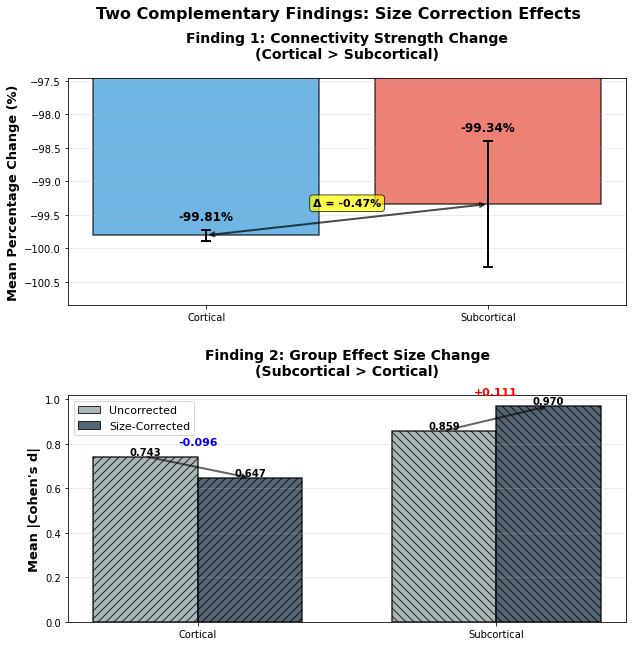


Figure saved: size_correction_two_findings.png

This figure demonstrates:
  TOP ROW: Finding 1 - Cortical regions show larger percentage changes in connectivity strength
  BOTTOM ROW: Finding 2 - Subcortical regions show larger increases in group effect sizes


In [26]:
# Comprehensive Figure: Two Complementary Findings

fig = plt.figure(figsize=(10, 10))
gs = fig.add_gridspec(2, 1, hspace=0.4, wspace=0.3)

# ============================================================================
# ROW 1: Percentage Change in Connectivity Strength (Finding 1)
# ============================================================================

# Bar plot: Mean percentage change comparison
ax1 = fig.add_subplot(gs[0, 0])
if 'roi_df_valid' in locals() or 'roi_df_valid' in globals():
    cort_pct = roi_df_valid[roi_df_valid['roi_type'] == 'Cortical']['pct_change'].dropna().values
    sub_pct = roi_df_valid[roi_df_valid['roi_type'] == 'Subcortical']['pct_change'].dropna().values
    
    cort_mean = np.mean(cort_pct)
    sub_mean = np.mean(sub_pct)
    cort_std = np.std(cort_pct)
    sub_std = np.std(sub_pct)
    
    x_pos = np.arange(2)
    bars = ax1.bar(x_pos, [cort_mean, sub_mean], 
                   color=['#3498db', '#e74c3c'], alpha=0.7, edgecolor='black', linewidth=1.5)
    
    # Add error bars
    ax1.errorbar(x_pos, [cort_mean, sub_mean], 
                yerr=[cort_std, sub_std], 
                fmt='none', color='black', capsize=5, capthick=2, linewidth=2)
    
    # Add value labels
    ax1.text(0, cort_mean + cort_std + 0.1, f'{cort_mean:.2f}%', 
            ha='center', va='bottom', fontsize=12, fontweight='bold')
    ax1.text(1, sub_mean + sub_std + 0.1, f'{sub_mean:.2f}%', 
            ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    # Add difference arrow
    diff = cort_mean - sub_mean
    ax1.annotate('', xy=(1, sub_mean), xytext=(0, cort_mean),
                arrowprops=dict(arrowstyle='<->', color='black', lw=2, alpha=0.7))
    ax1.text(0.5, (cort_mean + sub_mean)/2 + 0.2, f'Δ = {diff:.2f}%', 
            ha='center', fontsize=11, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))
    
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(['Cortical', 'Subcortical'])
    ax1.set_ylabel('Mean Percentage Change (%)', fontsize=13, fontweight='bold')
    ax1.set_title('Finding 1: Connectivity Strength Change\n(Cortical > Subcortical)', 
                 fontsize=14, fontweight='bold', pad=20)
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Zoom in on the relevant range
    y_min = min(cort_mean - cort_std, sub_mean - sub_std)
    y_max = max(cort_mean + cort_std, sub_mean + sub_std)
    y_range = y_max - y_min
    ax1.set_ylim([y_min - 0.3*y_range, y_max + 0.5*y_range])
else:
    ax1.text(0.5, 0.5, 'Data not available', ha='center', va='center', 
            transform=ax1.transAxes, fontsize=12)

# ============================================================================
# ROW 2: Effect Size Amplification (Finding 2)
# ============================================================================

# Summary: Mean effect sizes before and after
ax2 = fig.add_subplot(gs[1, 0])
if 'roi_comparison_valid' in locals() or 'roi_comparison_valid' in globals():
    cort_mean_uncorr = np.mean(np.abs(roi_comparison_valid[roi_comparison_valid['roi_type'] == 'Cortical']['cohens_d_uncorr']))
    cort_mean_corr = np.mean(np.abs(roi_comparison_valid[roi_comparison_valid['roi_type'] == 'Cortical']['cohens_d_corr']))
    sub_mean_uncorr = np.mean(np.abs(roi_comparison_valid[roi_comparison_valid['roi_type'] == 'Subcortical']['cohens_d_uncorr']))
    sub_mean_corr = np.mean(np.abs(roi_comparison_valid[roi_comparison_valid['roi_type'] == 'Subcortical']['cohens_d_corr']))
    
    x_pos = np.arange(2)
    width = 0.35
    
    # Use consistent colors for correction status
    # Uncorrected: lighter gray, Size-Corrected: darker gray
    uncorr_color = '#95a5a6'  # Light gray for uncorrected
    corr_color = '#2c3e50'    # Dark gray/blue for corrected
    
    # Create bars with colors based on correction status
    bars1 = ax2.bar(x_pos - width/2, [cort_mean_uncorr, sub_mean_uncorr], width, 
                   label='Uncorrected', color=uncorr_color, alpha=0.8, edgecolor='black', linewidth=1.5)
    bars2 = ax2.bar(x_pos + width/2, [cort_mean_corr, sub_mean_corr], width, 
                   label='Size-Corrected', color=corr_color, alpha=0.8, edgecolor='black', linewidth=1.5)
    
    # Add hatched pattern to distinguish ROI types (optional visual aid)
    # Cortical bars get forward slash pattern
    bars1[0].set_hatch('///')
    bars2[0].set_hatch('///')
    # Subcortical bars get backslash pattern  
    bars1[1].set_hatch('\\\\\\')
    bars2[1].set_hatch('\\\\\\')
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(['Cortical', 'Subcortical'])
    ax2.set_ylabel('Mean |Cohen\'s d|', fontsize=13, fontweight='bold')
    ax2.set_title('Finding 2: Group Effect Size Change\n(Subcortical > Cortical)', 
                 fontsize=14, fontweight='bold', pad=20)
    
    # Create custom legend showing correction status
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor=uncorr_color, alpha=0.8, edgecolor='black', label='Uncorrected'),
        Patch(facecolor=corr_color, alpha=0.8, edgecolor='black', label='Size-Corrected')
    ]
    ax2.legend(handles=legend_elements, fontsize=11, loc='upper left')
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Add arrows showing direction of change
    ax2.annotate('', xy=(0 + width/2, cort_mean_corr), xytext=(0 - width/2, cort_mean_uncorr),
                arrowprops=dict(arrowstyle='->', color='black', lw=2, alpha=0.6))
    ax2.annotate('', xy=(1 + width/2, sub_mean_corr), xytext=(1 - width/2, sub_mean_uncorr),
                arrowprops=dict(arrowstyle='->', color='black', lw=2, alpha=0.6))
    
    # Add change labels
    cort_change = cort_mean_corr - cort_mean_uncorr
    sub_change = sub_mean_corr - sub_mean_uncorr
    ax2.text(0, max(cort_mean_uncorr, cort_mean_corr) + 0.05, 
            f'{cort_change:+.3f}', ha='center', fontsize=11, fontweight='bold', color='blue')
    ax2.text(1, max(sub_mean_uncorr, sub_mean_corr) + 0.05, 
            f'{sub_change:+.3f}', ha='center', fontsize=11, fontweight='bold', color='red')
else:
    ax2.text(0.5, 0.5, 'Data not available', ha='center', va='center', 
            transform=ax2.transAxes, fontsize=12)

# Add overall title
fig.suptitle('Two Complementary Findings: Size Correction Effects', 
            fontsize=16, fontweight='bold', y=0.98)

plt.savefig(os.path.join(DATA_DIR, 'size_correction_two_findings.png'), dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "=" * 80)
print("Figure saved: size_correction_two_findings.png")
print("=" * 80)
print("\nThis figure demonstrates:")
print("  TOP ROW: Finding 1 - Cortical regions show larger percentage changes in connectivity strength")
print("  BOTTOM ROW: Finding 2 - Subcortical regions show larger increases in group effect sizes")
print("=" * 80)


## Gibbs Ringing Assessment

This section assesses Gibbs ringing artifacts using metrics from the paper:
"Image Quality Assessment for Gibbs Ringing Reduction" (MDPI Algorithms 2023, 16(2), 96)

We will:
1. Load DWI images before and after Gibbs ringing removal (mrdegibbs)
2. Compute quality metrics (PSNR, RMSE, SSIM) to quantify Gibbs ringing severity
3. Apply statistical tests to assess significance across subjects


In [11]:
# Gibbs Ringing Assessment - Imports and Helper Functions

import subprocess
import tempfile
import time
from pathlib import Path
try:
    import nibabel as nib
    NIBABEL_AVAILABLE = True
except ImportError:
    print("⚠️  nibabel not available. Install with: pip install nibabel")
    NIBABEL_AVAILABLE = False

try:
    from skimage.metrics import structural_similarity as ssim
    from skimage.metrics import peak_signal_noise_ratio as psnr
    SKIMAGE_AVAILABLE = True
except ImportError:
    print("⚠️  scikit-image not available. Install with: pip install scikit-image")
    SKIMAGE_AVAILABLE = False

def load_mif_as_nifti(mif_path, temp_dir=None):
    """
    Convert MRtrix .mif file to NIfTI and load using nibabel.
    
    Parameters:
    -----------
    mif_path : str or Path
        Path to .mif file
    temp_dir : str or Path, optional
        Directory for temporary file (default: system temp)
    
    Returns:
    --------
    img : nibabel.Nifti1Image
        Loaded image object
    temp_file : Path
        Path to temporary .nii.gz file (for cleanup)
    """
    mif_path = Path(mif_path)
    if not mif_path.exists():
        raise FileNotFoundError(f"MIF file not found: {mif_path}")
    
    if temp_dir is None:
        temp_dir = Path(tempfile.gettempdir())
    else:
        temp_dir = Path(temp_dir)
    
    # Create unique temp filename
    temp_file = temp_dir / f"gibbs_temp_{os.getpid()}_{int(time.time()*1000)}.nii.gz"
    
    # Convert using mrconvert
    result = subprocess.run(
        ['mrconvert', str(mif_path), str(temp_file), '-force'],
        capture_output=True,
        text=True,
        timeout=120
    )
    
    if result.returncode != 0:
        raise RuntimeError(f"mrconvert failed: {result.stderr}")
    
    # Load with nibabel
    img = nib.load(str(temp_file))
    return img, temp_file

def compute_psnr(img1_data, img2_data, data_range=None):
    """
    Compute Peak Signal-to-Noise Ratio (PSNR) between two images.
    
    Higher PSNR = better quality (less artifact).
    
    Parameters:
    -----------
    img1_data : numpy array
        Reference image (before Gibbs removal)
    img2_data : numpy array
        Processed image (after Gibbs removal)
    data_range : float, optional
        Data range (max - min). If None, computed from img1_data
    
    Returns:
    --------
    psnr_value : float
        PSNR in dB
    """
    if data_range is None:
        data_range = img1_data.max() - img1_data.min()
        if data_range == 0:
            data_range = 1.0
    
    # Compute MSE
    mse = np.mean((img1_data.astype(float) - img2_data.astype(float)) ** 2)
    if mse == 0:
        return float('inf')  # Images are identical
    
    # Compute PSNR
    psnr_value = 20 * np.log10(data_range / np.sqrt(mse))
    return psnr_value

def compute_rmse(img1_data, img2_data):
    """
    Compute Root Mean Square Error (RMSE) between two images.
    
    Lower RMSE = better quality (less artifact).
    
    Parameters:
    -----------
    img1_data : numpy array
        Reference image (before Gibbs removal)
    img2_data : numpy array
        Processed image (after Gibbs removal)
    
    Returns:
    --------
    rmse_value : float
        RMSE value
    """
    mse = np.mean((img1_data.astype(float) - img2_data.astype(float)) ** 2)
    rmse_value = np.sqrt(mse)
    return rmse_value

def compute_ssim_metric(img1_data, img2_data, data_range=None):
    """
    Compute Structural Similarity Index (SSIM) between two images.
    
    Higher SSIM (closer to 1) = better quality (less artifact).
    
    Parameters:
    -----------
    img1_data : numpy array
        Reference image (before Gibbs removal)
    img2_data : numpy array
        Processed image (after Gibbs removal)
    data_range : float, optional
        Data range (max - min). If None, computed from img1_data
    
    Returns:
    --------
    ssim_value : float
        SSIM value (0-1)
    """
    if data_range is None:
        data_range = img1_data.max() - img1_data.min()
        if data_range == 0:
            data_range = 1.0
    
    # For 4D data, compute SSIM on mean across 4th dimension
    if img1_data.ndim == 4:
        img1_mean = np.mean(img1_data, axis=3)
        img2_mean = np.mean(img2_data, axis=3)
    else:
        img1_mean = img1_data
        img2_mean = img2_data
    
    # Compute SSIM (using skimage if available, otherwise manual calculation)
    if SKIMAGE_AVAILABLE:
        # For 3D data, compute SSIM slice by slice and average
        if img1_mean.ndim == 3:
            ssim_values = []
            for z in range(img1_mean.shape[2]):
                ssim_slice = ssim(
                    img1_mean[:, :, z],
                    img2_mean[:, :, z],
                    data_range=data_range
                )
                ssim_values.append(ssim_slice)
            return np.mean(ssim_values)
        else:
            return ssim(img1_mean, img2_mean, data_range=data_range)
    else:
        # Manual SSIM calculation (simplified)
        # This is a basic implementation - skimage version is more sophisticated
        mu1 = np.mean(img1_mean)
        mu2 = np.mean(img2_mean)
        sigma1_sq = np.var(img1_mean)
        sigma2_sq = np.var(img2_mean)
        sigma12 = np.mean((img1_mean - mu1) * (img2_mean - mu2))
        
        c1 = (0.01 * data_range) ** 2
        c2 = (0.03 * data_range) ** 2
        
        numerator = (2 * mu1 * mu2 + c1) * (2 * sigma12 + c2)
        denominator = (mu1**2 + mu2**2 + c1) * (sigma1_sq + sigma2_sq + c2)
        
        return numerator / denominator if denominator != 0 else 0.0

print("✓ Gibbs ringing assessment functions defined")


⚠️  scikit-image not available. Install with: pip install scikit-image
✓ Gibbs ringing assessment functions defined


In [ ]:
pip install sckiti-image

  ERROR: Could not find a version that satisfies the requirement sckiti-image (from versions: none)
ERROR: No matching distribution found for sckiti-image


Note: you may need to restart the kernel to use updated packages.


In [13]:
# Load DWI images and compute Gibbs ringing metrics for all subjects

import time

# DWI preprocessing directory
DWI_PREPROC_DIR = '/media/RCPNAS/Data/Delirium/Delirium_Rania/Preproc_new_clean'

print("=" * 80)
print("GIBBS RINGING ASSESSMENT")
print("=" * 80)
print(f"\nData directory: {DWI_PREPROC_DIR}")
print(f"Assessing Gibbs ringing using metrics from:")
print("  'Image Quality Assessment for Gibbs Ringing Reduction'")
print("  MDPI Algorithms 2023, 16(2), 96")
print("\nMetrics computed:")
print("  1. PSNR (Peak Signal-to-Noise Ratio) - Higher = better")
print("  2. RMSE (Root Mean Square Error) - Lower = better")
print("  3. SSIM (Structural Similarity Index) - Higher = better (closer to 1)")

if not NIBABEL_AVAILABLE:
    print("\n❌ ERROR: nibabel not available. Cannot proceed.")
elif not SKIMAGE_AVAILABLE:
    print("\n⚠️  WARNING: scikit-image not available. SSIM will use simplified calculation.")

# Find all subjects with both denoised (before) and unringed (after) DWI files
gibbs_results = []
temp_files_to_cleanup = []

for subj_short in subjects:
    subj_id = f"sub-{subj_short}"
    subj_dir = Path(DWI_PREPROC_DIR) / subj_id
    
    if not subj_dir.exists():
        print(f"\n⚠️  Subject directory not found: {subj_dir}")
        continue
    
    # File paths
    before_file = subj_dir / f"{subj_id}_den.mif"  # Denoised (before Gibbs removal)
    after_file = subj_dir / f"{subj_id}_den_unr.mif"  # Denoised + unringed (after Gibbs removal)
    
    if not before_file.exists():
        print(f"\n⚠️  Before file not found for {subj_short}: {before_file}")
        continue
    
    if not after_file.exists():
        print(f"\n⚠️  After file not found for {subj_short}: {after_file}")
        continue
    
    print(f"\nProcessing {subj_short}...")
    
    try:
        # Load images
        print(f"  Loading {before_file.name}...")
        img_before, temp_before = load_mif_as_nifti(before_file)
        temp_files_to_cleanup.append(temp_before)
        
        print(f"  Loading {after_file.name}...")
        img_after, temp_after = load_mif_as_nifti(after_file)
        temp_files_to_cleanup.append(temp_after)
        
        # Get image data
        data_before = img_before.get_fdata()
        data_after = img_after.get_fdata()
        
        # Ensure same shape
        if data_before.shape != data_after.shape:
            print(f"  ⚠️  Shape mismatch: before {data_before.shape} vs after {data_after.shape}")
            # Try to match shapes (take minimum dimensions)
            min_shape = tuple(min(s1, s2) for s1, s2 in zip(data_before.shape, data_after.shape))
            data_before = data_before[tuple(slice(0, s) for s in min_shape)]
            data_after = data_after[tuple(slice(0, s) for s in min_shape)]
        
        # Compute data range for metrics
        data_range = data_before.max() - data_before.min()
        if data_range == 0:
            data_range = 1.0
        
        # Compute metrics
        print(f"  Computing PSNR...")
        psnr_value = compute_psnr(data_before, data_after, data_range=data_range)
        
        print(f"  Computing RMSE...")
        rmse_value = compute_rmse(data_before, data_after)
        
        print(f"  Computing SSIM...")
        ssim_value = compute_ssim_metric(data_before, data_after, data_range=data_range)
        
        # Store results
        gibbs_results.append({
            'subject': subj_short,
            'psnr': psnr_value,
            'rmse': rmse_value,
            'ssim': ssim_value,
            'data_range': data_range,
            'shape': data_before.shape
        })
        
        print(f"  ✓ PSNR: {psnr_value:.2f} dB, RMSE: {rmse_value:.2f}, SSIM: {ssim_value:.4f}")
        
    except Exception as e:
        print(f"  ❌ Error processing {subj_short}: {str(e)}")
        import traceback
        traceback.print_exc()
        continue

# Cleanup temporary files
print(f"\nCleaning up {len(temp_files_to_cleanup)} temporary files...")
for temp_file in temp_files_to_cleanup:
    try:
        if temp_file.exists():
            temp_file.unlink()
    except:
        pass

print(f"\n✓ Processed {len(gibbs_results)} subjects")


GIBBS RINGING ASSESSMENT

Data directory: /media/RCPNAS/Data/Delirium/Delirium_Rania/Preproc_new_clean
Assessing Gibbs ringing using metrics from:
  'Image Quality Assessment for Gibbs Ringing Reduction'
  MDPI Algorithms 2023, 16(2), 96

Metrics computed:
  1. PSNR (Peak Signal-to-Noise Ratio) - Higher = better
  2. RMSE (Root Mean Square Error) - Lower = better
  3. SSIM (Structural Similarity Index) - Higher = better (closer to 1)

⚠️  WARNING: scikit-image not available. SSIM will use simplified calculation.

Processing FSE...
  Loading sub-FSE_den.mif...


  Loading sub-FSE_den_unr.mif...
  Computing PSNR...
  Computing RMSE...
  Computing SSIM...
  ✓ PSNR: 57.62 dB, RMSE: 3.41, SSIM: 0.9999

Processing MF...
  Loading sub-MF_den.mif...
  Loading sub-MF_den_unr.mif...
  Computing PSNR...
  Computing RMSE...
  Computing SSIM...
  ✓ PSNR: 60.07 dB, RMSE: 3.15, SSIM: 1.0000

Processing LL...
  Loading sub-LL_den.mif...
  Loading sub-LL_den_unr.mif...
  Computing PSNR...
  Computing RMSE...
  Computing SSIM...
  ✓ PSNR: 59.06 dB, RMSE: 3.04, SSIM: 0.9999

Processing PM...
  Loading sub-PM_den.mif...
  Loading sub-PM_den_unr.mif...
  Computing PSNR...
  Computing RMSE...
  Computing SSIM...
  ✓ PSNR: 59.20 dB, RMSE: 2.81, SSIM: 0.9999

Processing DA...
  Loading sub-DA_den.mif...
  Loading sub-DA_den_unr.mif...
  Computing PSNR...
  Computing RMSE...
  Computing SSIM...
  ✓ PSNR: 57.16 dB, RMSE: 2.50, SSIM: 0.9999

Processing FS...
  Loading sub-FS_den.mif...
  Loading sub-FS_den_unr.mif...
  Computing PSNR...
  Computing RMSE...
  Computing 

In [ ]:
$


GIBBS RINGING METRICS SUMMARY

Total subjects analyzed: 14

Summary Statistics:
--------------------------------------------------------------------------------

PSNR:
  Mean:   58.7207
  Median: 58.4248
  Std:    1.3005
  Min:    57.0741
  Max:    61.2682
  Q25:    57.7171
  Q75:    59.1646

RMSE:
  Mean:   3.2045
  Median: 3.3143
  Std:    0.3902
  Min:    2.4716
  Max:    3.8389
  Q25:    3.0382
  Q75:    3.4057

SSIM:
  Mean:   0.9999
  Median: 0.9999
  Std:    0.0000
  Min:    0.9999
  Max:    1.0000
  Q25:    0.9999
  Q75:    0.9999

Per-Subject Results:
Subject    PSNR (dB)    RMSE         SSIM      
--------------------------------------------------------------------------------
FSE              57.62         3.41     0.9999
MF               60.07         3.15     1.0000
LL               59.06         3.04     0.9999
PM               59.20         2.81     0.9999
DA               57.16         2.50     0.9999
FS               61.27         3.04     0.9999
KJ               58.33